# DAAO venues and organisations

This is an exploratory data analysis of collected data from [DAAO](https://www.daao.org.au/). We focus on venues and organisations adopting natural language processing to reveal patterns in the data.

The visualisations consist of...
- word clouds
- dendrograms
- time series and temporal bar charts

In [5]:
import pandas as pd
import numpy as np
import json
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go

# dfs = pd.read_csv('data/acde_event_202304010318.csv', low_memory=False)

# dfs_expanded = []

# # get start and end years
# for idx,row in dfs[dfs.data_source == 'DAAO'].iterrows():
#     try: 
#         this_locations = pd.json_normalize(eval(row['locations'].replace("ObjectId('","'").replace("')","'")))

#         for idx2, row2 in this_locations.iterrows():
#             try: start_yr = row2['coverage_range.date_range.date_start.year']
#             except: start_yr = None

#             try: end_yr = row2['coverage_range.date_range.date_end.year']
#             except: end_yr = None

#             try: place_address = row2['coverage_range.place.ori_address']
#             except: place_address = None

#             try: 
#                 latitude = row2['coverage_range.place.geo_coord.latitude']
#                 longitude = row2['coverage_range.place.geo_coord.longitude']
#             except:
#                 latitude = None; longitude = None

#             row['start_year'] = int(start_yr); row['end_year'] = int(end_yr)
#             row['latitude'] = latitude; row['longitude'] = longitude
#             row['place_address'] = place_address
#             dfs_expanded.append(row)

#     except:
#         start_yr = None; end_yr = None; latitude = None; longitude = None; place_address = None
#         dfs_expanded.append(row)

# pd.DataFrame(dfs_expanded).to_csv('data/acde_event_expanded.csv', index=False)

# read in expanded data
dfs_expanded = pd.read_csv('data/acde_event_expanded.csv', low_memory=False)

locations_cond = dfs_expanded.latitude.notnull()
year_cond = dfs_expanded.start_year.notnull()
desc_cond = dfs_expanded.description.notnull()
period_cond = (dfs_expanded.start_year >= 1900) & (dfs_expanded.start_year <= 2020)

print('In DAAO,') 
print(f'- there are {dfs_expanded.shape[0]} events.')
print(f'- there are {dfs_expanded[year_cond].shape[0]} events with dates.')
print(f'- there are {dfs_expanded[locations_cond & year_cond].shape[0]} events with geocodes and dates.')
print(f'- there are {dfs_expanded[locations_cond & year_cond & desc_cond].shape[0]} events with geocodes, dates and biographical information.')
print(f'- there are {dfs_expanded[locations_cond & year_cond & desc_cond & period_cond].shape[0]} events with geocodes, dates and biographical information after filtering for events between 1900 and 2020.')

In DAAO,
- there are 22524 events.
- there are 21242 events with dates.
- there are 17764 events with geocodes and dates.
- there are 7751 events with geocodes, dates and biographical information.
- there are 7581 events with geocodes, dates and biographical information after filtering for events between 1900 and 2020.


In [6]:
dfs_rich = dfs_expanded[locations_cond & year_cond & desc_cond & period_cond].copy()

type_count = dfs_rich['types'].value_counts().reset_index().rename(columns={'index':'type','types':'count'})
type_count['prop'] = round((type_count['count']/dfs_rich.shape[0])*100,2)
exh_prop = type_count['type'].str.contains('exhibition')
other_prop = type_count['type'].str.contains('other event')
fest_prop = type_count['type'].str.contains('festival')
perf_prop = type_count['type'].str.contains('performance')

# # create a decade column
dfs_rich['decade_start'] = [str(int(x))[:3]+'0' for x in dfs_rich['start_year']]
dfs_rich['decade_start'] = dfs_rich['decade_start'].astype(int)

print('\nWe use the 7,581 events for the remainder of the analysis. In this subset,') 
print(f'- there are {type_count[exh_prop]["count"].sum()} exhibitions ({round(type_count[exh_prop]["prop"].sum(),2)}%).')
print(f'- there are {type_count[other_prop]["count"].sum()} other-events ({round(type_count[other_prop]["prop"].sum(),2)}%).')
print(f'- there are {type_count[fest_prop]["count"].sum()} festivals ({round(type_count[fest_prop]["prop"].sum(),2)}%).')
print(f'- there are {type_count[perf_prop]["count"].sum()} performance-event ({round(type_count[perf_prop]["prop"].sum(),2)}%).')
print(f'- there are {dfs_rich["types"].isnull().sum()} events with missing type data ({round((dfs_rich["types"].isnull().sum()/dfs_rich.shape[0])*100,2)}%).')

print('\nIn terms of time,')
for t in range(1900,2021,10):
    if t != 2020: print(f'- there are {dfs_rich[dfs_rich.decade_start == t].shape[0]} events between {t}-{t+10} ({round((dfs_rich[dfs_rich.decade_start == t].shape[0]/dfs_rich.shape[0])*100,2)}%).')
    else: print(f'- there are {dfs_rich[dfs_rich.start_year == t].shape[0]} events in {t} ({round((dfs_rich[dfs_rich.start_year == t].shape[0]/dfs_rich.shape[0])*100,2)}%).')


We use the 7,581 events for the remainder of the analysis. In this subset,
- there are 6940 exhibitions (91.55%).
- there are 86 other-events (1.13%).
- there are 32 festivals (0.42%).
- there are 21 performance-event (0.28%).
- there are 508 events with missing type data (6.7%).

In terms of time,
- there are 33 events between 1900-1910 (0.44%).
- there are 31 events between 1910-1920 (0.41%).
- there are 39 events between 1920-1930 (0.51%).
- there are 40 events between 1930-1940 (0.53%).
- there are 41 events between 1940-1950 (0.54%).
- there are 90 events between 1950-1960 (1.19%).
- there are 159 events between 1960-1970 (2.1%).
- there are 651 events between 1970-1980 (8.59%).
- there are 1413 events between 1980-1990 (18.64%).
- there are 2272 events between 1990-2000 (29.97%).
- there are 2283 events between 2000-2010 (30.11%).
- there are 526 events between 2010-2020 (6.94%).
- there are 3 events in 2020 (0.04%).


## Most frequent geocodes

Before jumping into the visuals, we inspect the nuances of the geocodes attached to exhibtion data. We find that the geocodes are not always accurate, and that there are many distinct venues representing the same geocode. Further pre-processing will need to be conducted to ensure downstream trends can be accurately identified. 

Below is a list of the top 20 geocodes, and the number of events they represent. Through further inspection we can see which geocodes accurate represent the place names.

In [83]:
most_freq_geocodes = dfs_rich[['latitude','longitude']].value_counts().reset_index().rename(columns={0:'Frequency'})
most_freq_geocodes = most_freq_geocodes.head(20)

# get the most frequent place_address for each geocode
for idx,row in most_freq_geocodes.iterrows():
    place_address = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[0]

    try: place_address2 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[1]
    except: place_address2 = None
    
    try: place_address3 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[2]
    except: place_address3 = None

    try: place_address4 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[3]
    except: place_address4 = None

    try: place_address5 = dfs_rich[(dfs_rich.latitude == row['latitude']) & (dfs_rich.longitude == row['longitude'])]['place_address'].value_counts().index[4]
    except: place_address5 = None
    
    most_freq_geocodes.loc[idx,'most_frequent_address'] = place_address
    most_freq_geocodes.loc[idx,'2ndmost_frequent_address'] = place_address2
    most_freq_geocodes.loc[idx,'3rdmost_frequent_address'] = place_address3
    most_freq_geocodes.loc[idx,'4thmost_frequent_address'] = place_address4
    most_freq_geocodes.loc[idx,'5thmost_frequent_address'] = place_address5

most_freq_geocodes

latitude   longitude  Frequency  \
0  -34.928621  138.599959        936   
1  -33.868901  151.207091        898   
2  -37.813187  144.962980        502   
3  -27.470933  153.023502        494   
4  -33.868627  151.217062        321   
5  -34.416667  150.883333        192   
6  -12.437368  130.833821        152   
7  -37.822536  144.969113        134   
8  -27.472096  153.018173        133   
9  -32.929205  151.772973        126   
10 -31.952222  115.858889        117   
11 -33.281886  149.102659        109   
12 -38.385530  142.482454        108   
13 -31.950414  115.860604        106   
14 -33.872355  151.224854        103   
15 -41.437456  147.134155         95   
16 -33.884611  151.226586         94   
17 -37.562107  143.856149         92   
18 -33.888493  151.187100         86   
19 -37.758900  145.084301         85   

                                most_frequent_address  \
0           Experimental Art Foundation, Adelaide, SA   
1                               Artspace, Sydney, NSW   
2     Monash University Museum of Art, Melbourne, VIC   
3              Institute of Modern Art, Brisbane, QLD   
4         Art Gallery of New South Wales, Sydney, NSW   
5            Wollongong City Gallery, Wollongong, NSW   
6   Museums and Art Galleries of the Northern Terr...   
7        National Gallery of Victoria, Melbourne, VIC   
8               Queensland Art Gallery, Brisbane, QLD   
9        Newcastle Region Art Gallery, Newcastle, NSW   
10  John Curtin Gallery, Curtin University, Perth, WA   
11               Orange Regional Gallery, Orange, NSW   
12          Warrnambool Art Gallery, Warrnambool, VIC   
13        Art Gallery of Western Australia, Perth, WA   
14       8 Llankelly Place, Kings Cross, Sydney, 2011   
15  Queen Victoria Museum and Art Gallery, Launces...   
16  Ivan Dougherty Gallery, COFA, UNSW, Paddington...   
17           Ballarat Fine Art Gallery, Ballarat, VIC   
18  Tin Sheds Gallery, University of Sydney, Sydne...   
19         Heide Museum of Modern Art, Melbourne, VIC   

                             2ndmost_frequent_address  \
0   Contemporary Art Centre of South Australia, Ad...   
1                                         Sydney, NSW   
2   Australian Centre for Contemporary Art, Melbou...   
3            Brisbane City Art Gallery, Brisbane, Qld   
4                     Art Gallery of NSW, Sydney, NSW   
5        Wollongong City Art Gallery, Wollongong, NSW   
6   Museum and Art Gallery of the Northern Territo...   
7       National Gallery of Victoria, Melbourne, Vic.   
8               Queensland Art Gallery, Brisbane, Qld   
9   Newcastle City Art Gallery, Newcastle, New Sou...   
10                                          Perth, WA   
11           Orange Regional Art Gallery, Orange, NSW   
12                       Warrnambool Art Gallery, VIC   
13  Art Gallery of Western Australia, Perth, WA (a...   
14                                               None   
15  Queen Victoria Museum and Art Gallery, Launces...   
16     Roslyn Oxley9 Gallery, Paddington, Sydney, NSW   
17                                      Ballarat, VIC   
18  Sydney College of the Arts, University of Sydn...   
19          Heide Museum of Modern Art, Bulleen, Vic.   

                             3rdmost_frequent_address  \
0              Adelaide Central Gallery, Adelaide, SA   
1                      Sherman Galleries, Sydney, NSW   
2                        RMIT Gallery, Melbourne, VIC   
3                                       Brisbane, Qld   
4         Art Gallery Of New South Wales, Sydney, NSW   
5      Project Contemporary Artspace, Wollongong, NSW   
6   Museum & Art Gallery of the Northern Territory...   
7   Ian Potter Centre, National Gallery of Victori...   
8              Queensland Art Gallery, Brisbane, Qld.   
9      Newcastle Regional Art Gallery, Newcastle, NSW   
10     Perth Institute of Contemporary Art, Perth, WA   
11                       Orange Regional Gallery, NSW   
12                         

### Top 10 geocoded places with most events

After omitting geocodes with random or erroneous place names, we can see that the "true" top 10 geocoded places with the most events. As expected these are all art galleries - all with over 100 events.

| Venue | City | Frequency |
| :- | -: | -: |
| Art Gallery of New South Wales | Sydney, NSW | 321 |
| Wollongong City Gallery | Wollongong, NSW | 192 |
| Museums and Art Galleries of the Northern Territory | Darwin, NT | 152 |
| National Gallery of Victoria | Melbourne, VIC | 134 |
| Queensland Art Gallery | Brisbane, QLD	| 133 |
| Newcastle Region Art Gallery | Newcastle, NSW | 126 |
| Orange Regional Gallery | Orange, NSW | 109 |
| Warrnambool Art Gallery | Warrnambool, VIC | 108 |
| Art Gallery of Western Australia | Perth, WA | 106 |
| 8 Llankelly Place, Kings Cross | Sydney, NSW | 103 |

## Most frequent terms used for place names

From here, we explore the most frequent terms used for place names. We find that the most frequent terms are "Gallery", "Art", "Centre", "Museum", and "University".

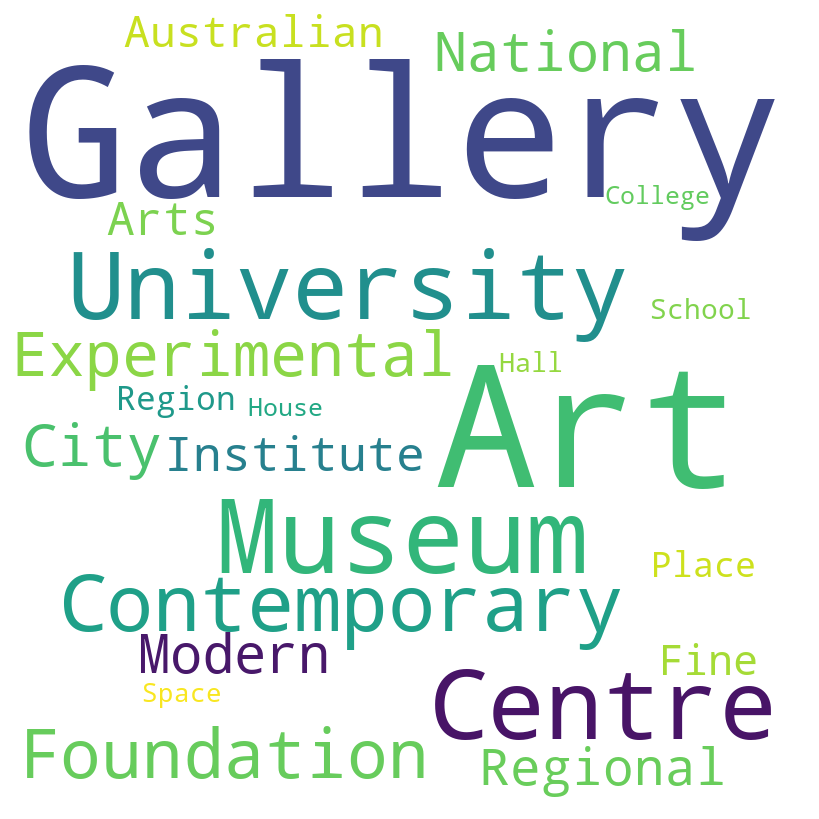

In [101]:
# find the most frequent words across the strings for place names
from collections import Counter
import matplotlib.pyplot as plt

import nltk
# nltk.download('punkt')

from nltk.tokenize import word_tokenize

# create a list of all the place names
all_place_names = dfs_rich['place_address'].astype(str).tolist()

# create a list of all the words in the place names
all_words = []
for place_name in all_place_names:
    all_words.extend(word_tokenize(place_name))

# find top 100 most frequent words
most_freq_words = Counter(all_words).most_common(89)

# remove a list of all words that are not relevant
words_to_remove = [',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
                   '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
                   'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
                   'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
                   'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
                   'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
                   '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
                   'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide','Tasmanian']

# remove the words from the list of most frequent words
most_freq_words = [word for word in most_freq_words if word[0] not in words_to_remove]

most_freq_words_dict = dict(most_freq_words)

# add value of two keys
most_freq_words_dict['Gallery'] = most_freq_words_dict['Gallery'] + most_freq_words_dict['Galleries']
most_freq_words_dict['Museum'] = most_freq_words_dict['Museum'] + most_freq_words_dict['Museums']

# remove key 'Gallery'
most_freq_words_dict.pop('Galleries')
most_freq_words_dict.pop('Museums')
most_freq_words_dict2 = most_freq_words_dict.copy()

# create a wordcloud with the most frequent words
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(most_freq_words_dict)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Hierarchical clustering using event description data 

Next we explore exhibition descriptions using hierarchical clustering; a method used to group similar objects into clusters that follow a hierarchical structure. This can help conceptualise what a taxonomy of venue categories might look like. We use two methods to embed the data, term frequency-inverse document frequency (TF-IDF) and Google's BERT.

The former is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. The latter is a language model that can embed a sense of "context" to the textual data. This means that the model can quantitatively encode the meaning of a word based on the words that surround it.

### Hierarchical clustering (tf-idf)

The first dendrogram shows the hierarchical clustering of the exhibition descriptions using TF-IDF. We cluster the data into seven groups. The x-axis provides a count (in brackets) of the exhibitition within each respective cluster. We also provide two sets of annotations. The annotations above the x-axis represent the most frequently occuring terms within the event description for each cluster. We limit this list to distinctive words. The annotations below the x-axis represent the most frequently occuring venues for each cluster.

In [120]:
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

### collect all relevant textual data from the dataframe
# if description is not \n then append to slug2 in one line
dfs_rich['slug2'] = dfs_rich['title'].fillna('') + dfs_rich['description'].apply(lambda x: '' if x == '\n' else x)

### pre-process for NLP
# Load the documents and their corresponding categorical variables into a Pandas dataframe
df = pd.DataFrame({'text': dfs_rich['slug2'], 'category': dfs_rich['place_address']})

# summarise text for each unique place name
df['text'] = df.groupby('category')['text'].transform(lambda x: ' '.join(x))

#add new column with count for each category
df['cat_count'] = df.groupby('category')['category'].transform('count')
df.drop_duplicates(inplace=True)

# Clean the text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.replace(',', '')
    text = text.lower().split()
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

df = df[df['text'].notnull()]
df['clean_text'] = df['text'].apply(clean_text)

# Vectorize the text
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])


### Generate clusters

def get_most_common_word(df, more_words = [], no_of_words=25):
    # remove a list of all words that are not relevant
    # words_to_remove = [',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
    #                 '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
    #                 'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
    #                 'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
    #                 'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
    #                 'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
    #                 '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
    #                 'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide','Place','Vic.',]
    
    words_to_remove = []
    
    # add more words to the list of words to remove
    words_to_remove = words_to_remove + more_words

    all_words = []
    for i in df:
        for j in i.split(' '):
            all_words.append(j.replace(',',''))

    # find the most common words
    most_common_words = Counter(all_words).most_common(no_of_words)

    # remove the words from the list of most frequent words
    most_common_words = [word for word in most_common_words if word[0] not in words_to_remove]
    return most_common_words

def get_linkage_matrix(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

# # setting distance_threshold=0 ensures we compute the full tree.
# model_tfidf = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_tfidf = model_tfidf.fit(X.toarray())

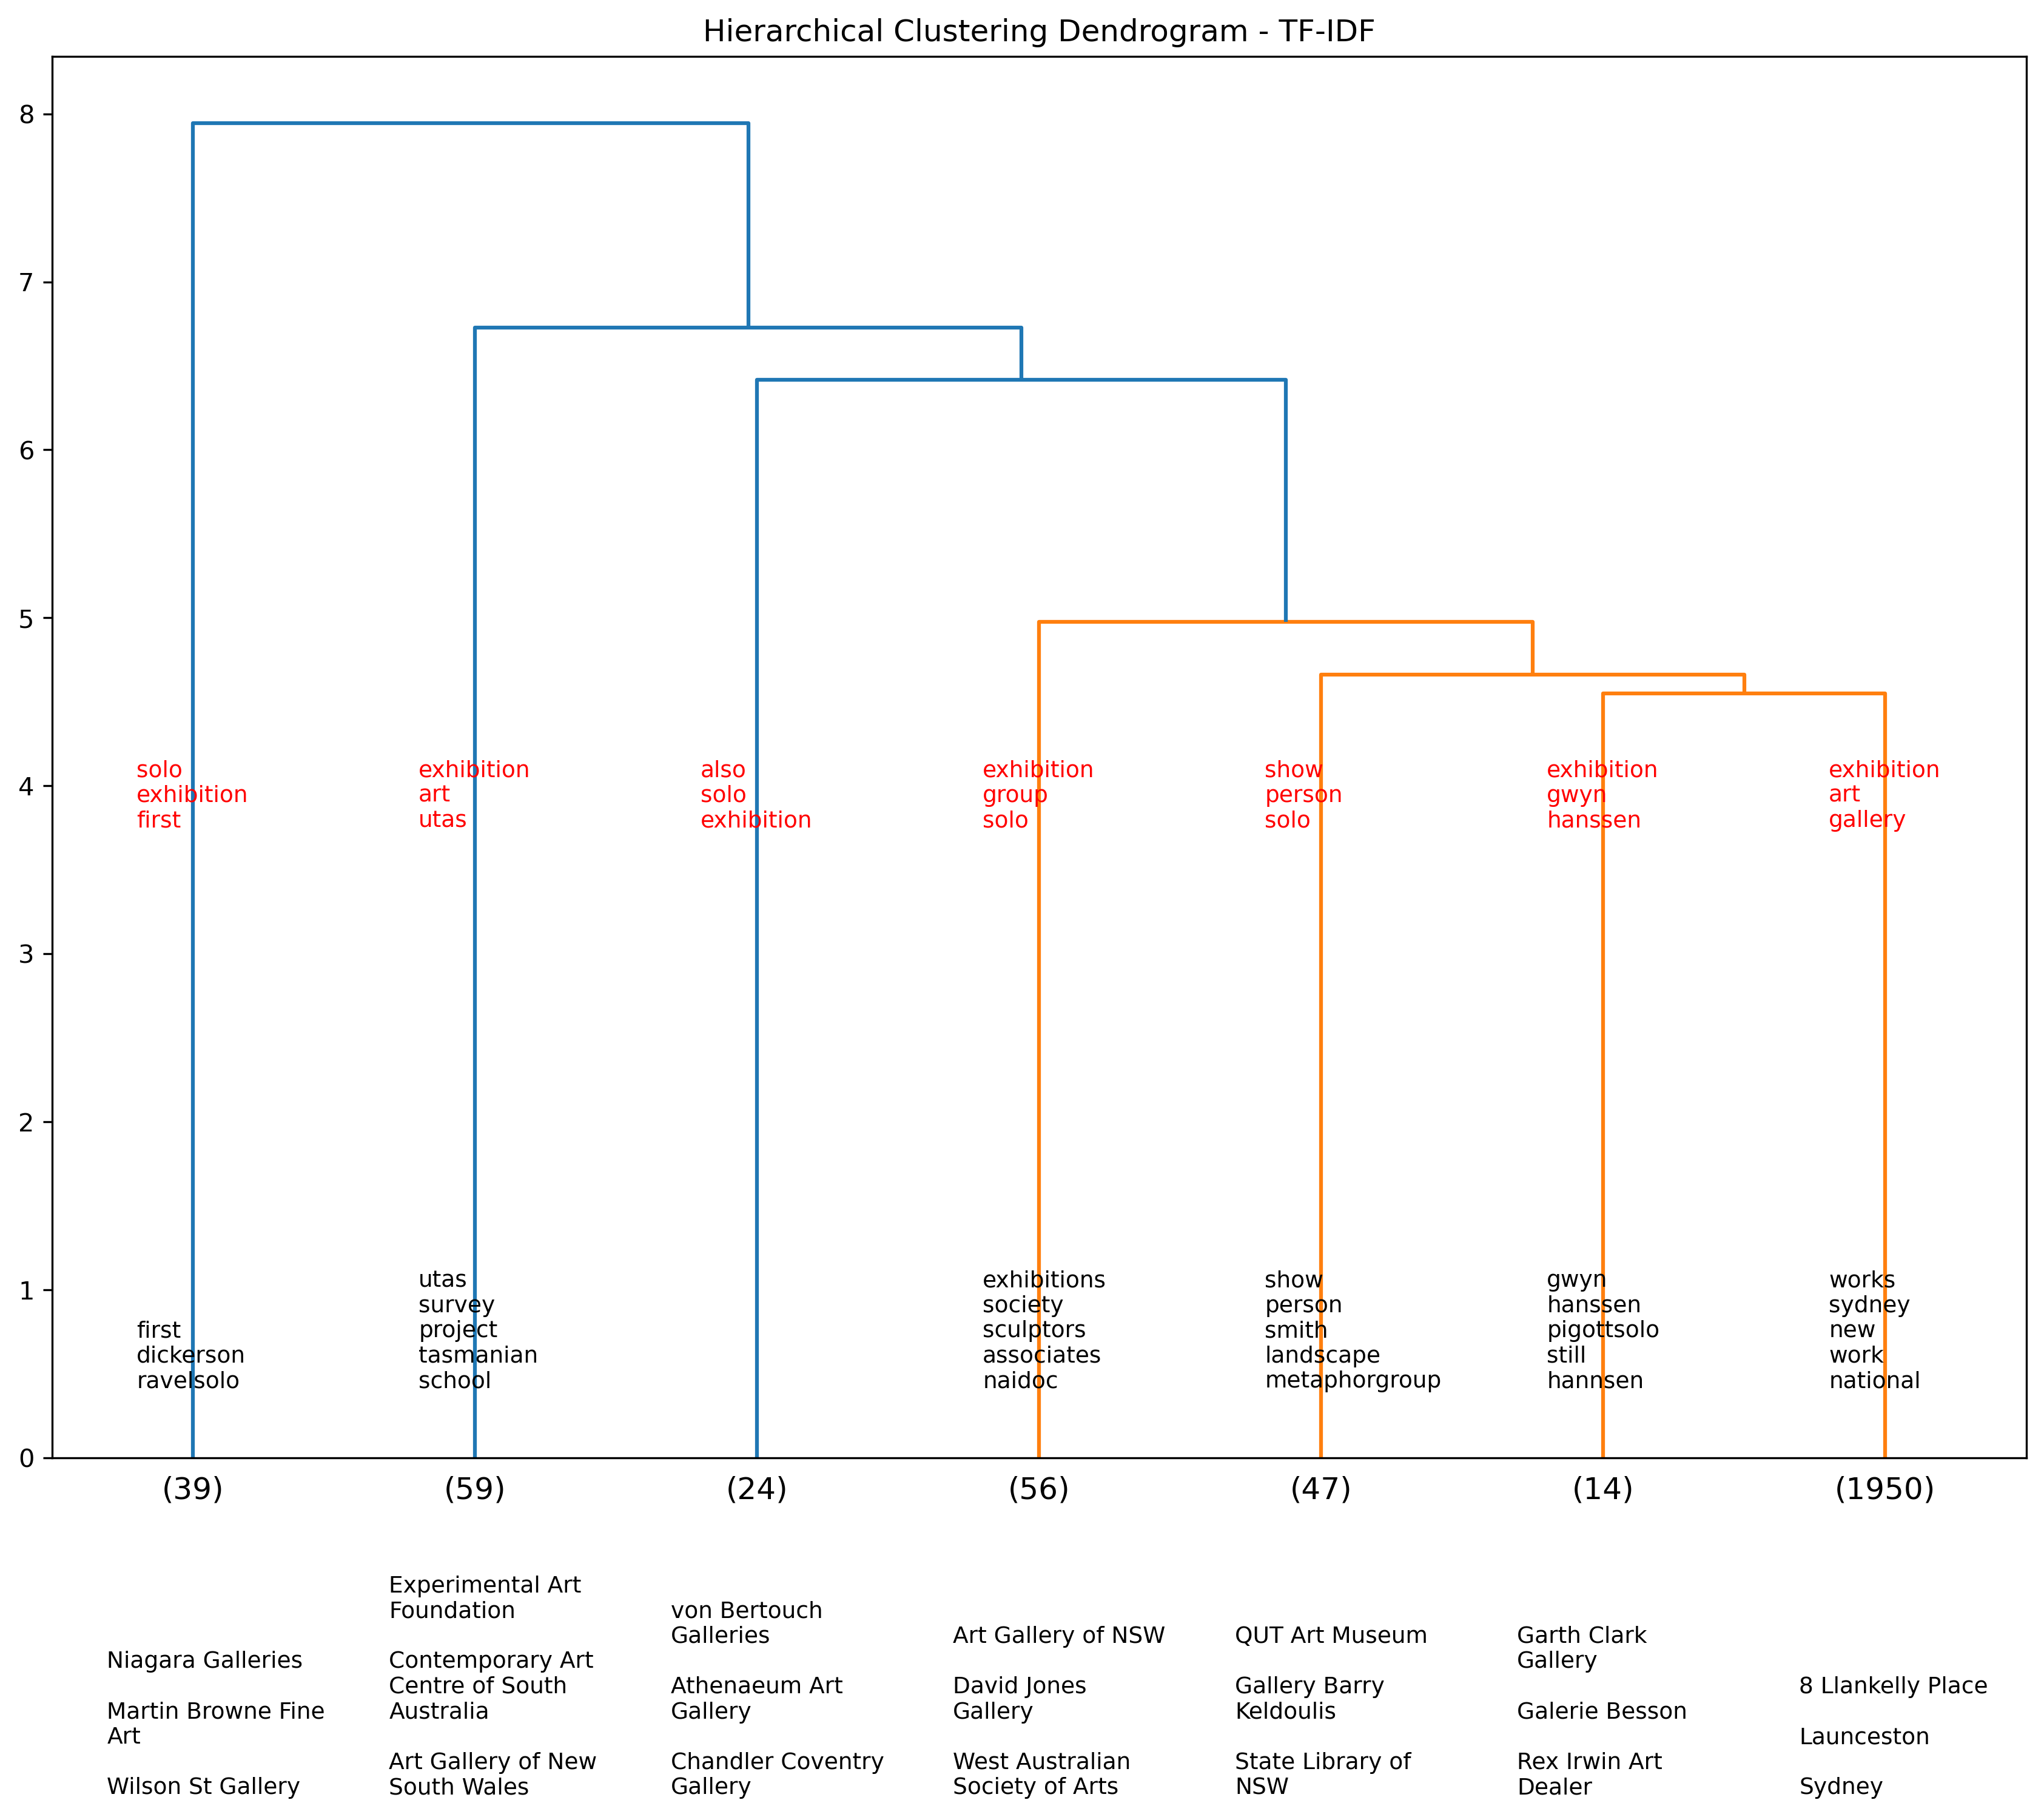

In [138]:
# from textwrap import wrap

# cut = 7
# l_matrix = get_linkage_matrix(model_tfidf)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# # if a word is a duplicate then remove from all_words
# def find_duplicates(all_words, occurences=1):
#     duplicates = []
#     non_duplicates = []

#     for i in all_words:
#         if i in duplicates: continue
#         else:
#             if all_words.count(i) > occurences: duplicates.append(i)
#             else: non_duplicates.append(i)
#     return duplicates

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'])) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.45), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.45), 
#                  xycoords='axes fraction', fontsize=9, color='red')
    
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=2)
# all_words_to_remove.extend(['j','th','nd','exhibitionexhibited'])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)
    
#     annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     plt.annotate(annot2, xy=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xytext=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - TF-IDF")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_tfidf.png', dpi=300, bbox_inches='tight')

from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_tfidf.png')

We provide the same visual however show the most frequent terms used within the place names as opposed to the event descriptions.

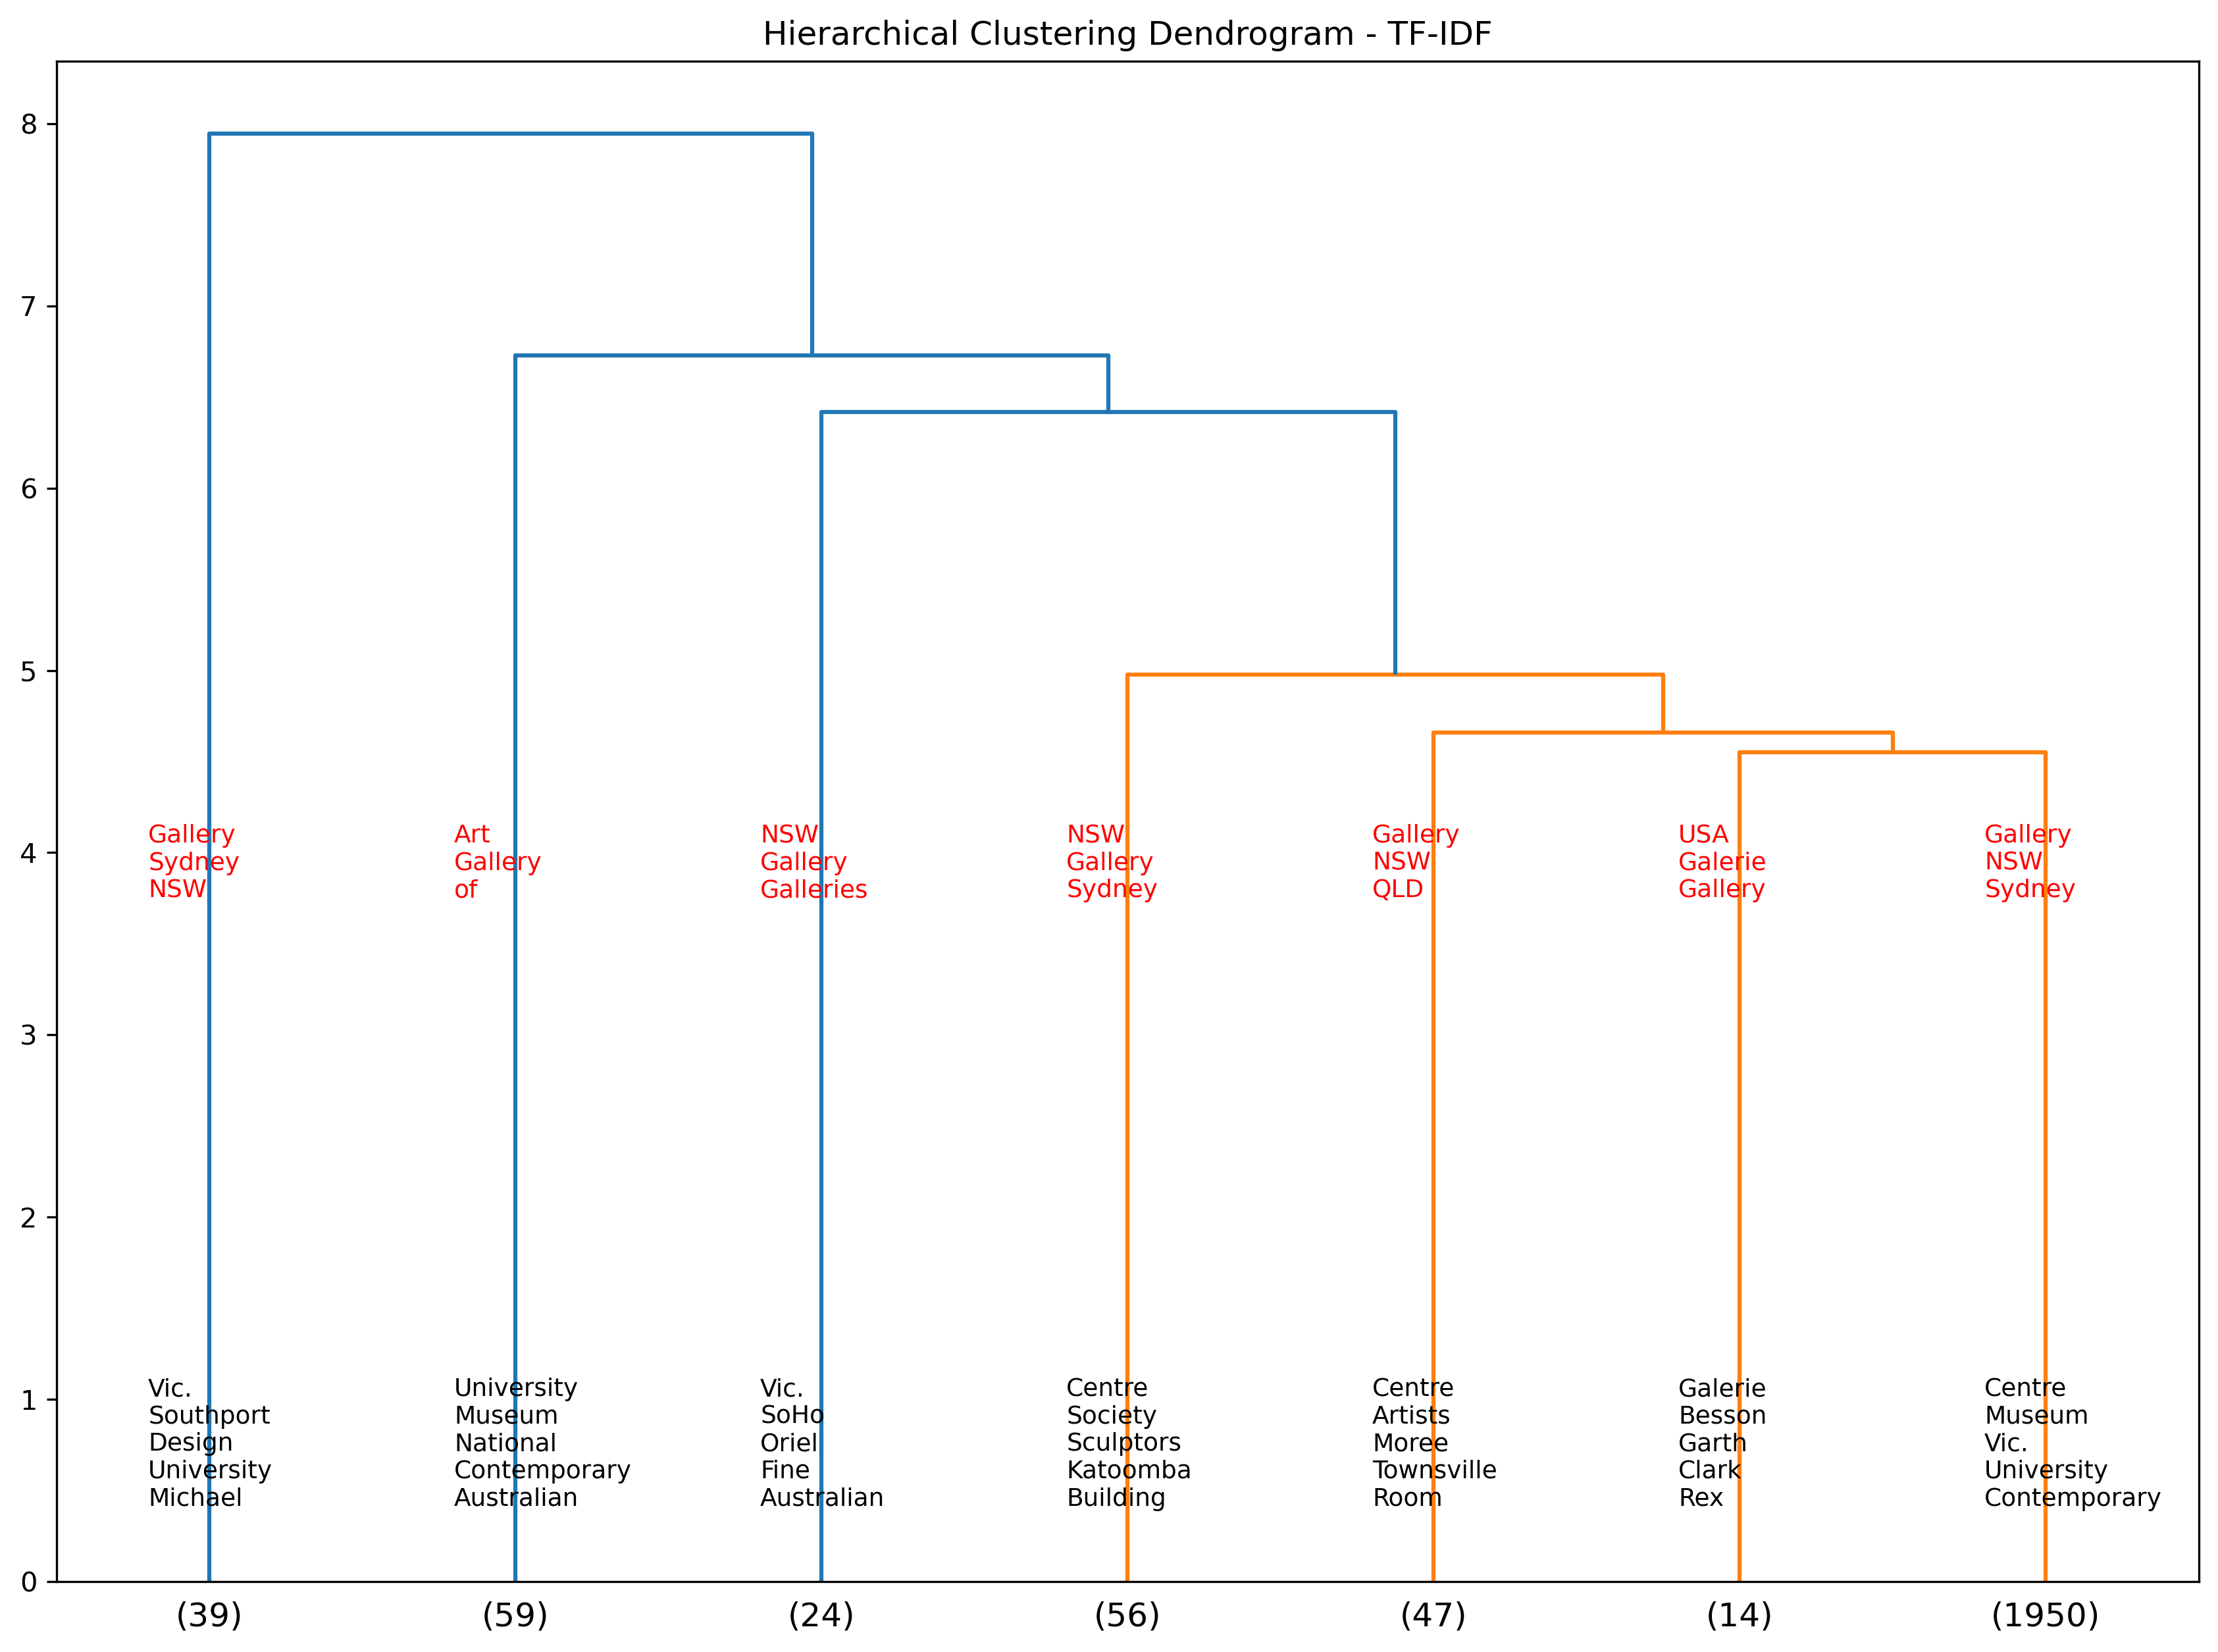

In [142]:
# cut = 7
# l_matrix = get_linkage_matrix(model_tfidf)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))

#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'])) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.45), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.45), 
#                  xycoords='axes fraction', fontsize=9, color='red')
    
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=3)

# all_words_to_remove.extend([',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
#                    '.', 'New', 'Australia', 'QLD', 'Vic', 'Wales', 'WA', 'Canberra', 'and',
#                    'Perth', 'ACT', 'of', 'Qld', 'Victoria','Wollongong','TAS','Queensland','Newcastle',
#                    'Street','Hobart','the','The','Launceston','Orange','UK','NT','London','USA',
#                    'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
#                    'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
#                    '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
#                    'Curtin','France','Tin','Sheds','York','Monash','Paris','Heide'])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - TF-IDF")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_tfidf_placename.png', dpi=300, bbox_inches='tight')

from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_tfidf_placename.png')

### Hierarchical clustering (BERT)

We repeat the methodology but now change the embedding method to BERT. We expect using BERT, a much more complex model, to better represent each venue. We find that the clusters are more widely populated, and output a different outcome.

In [143]:
# ### load bert model

# # !pip install transformers
# from transformers import BertTokenizer, BertModel
# from transformers import pipeline
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [146]:
# ### encode text using bert (takes 2mins to run)
# import random

# # encode the text using bert
# def bert_encode(x):
#   encoded_input = tokenizer(x, return_tensors='pt')
#   output = model(**encoded_input)
#   return pd.DataFrame(output['pooler_output'].detach().numpy()).T

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df['clean_text_sampled'] = df['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 340)) if len(x.split(' ')) >= 340 else x)
# X_bert = df['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert = model_bert.fit(np.array(X_bert))

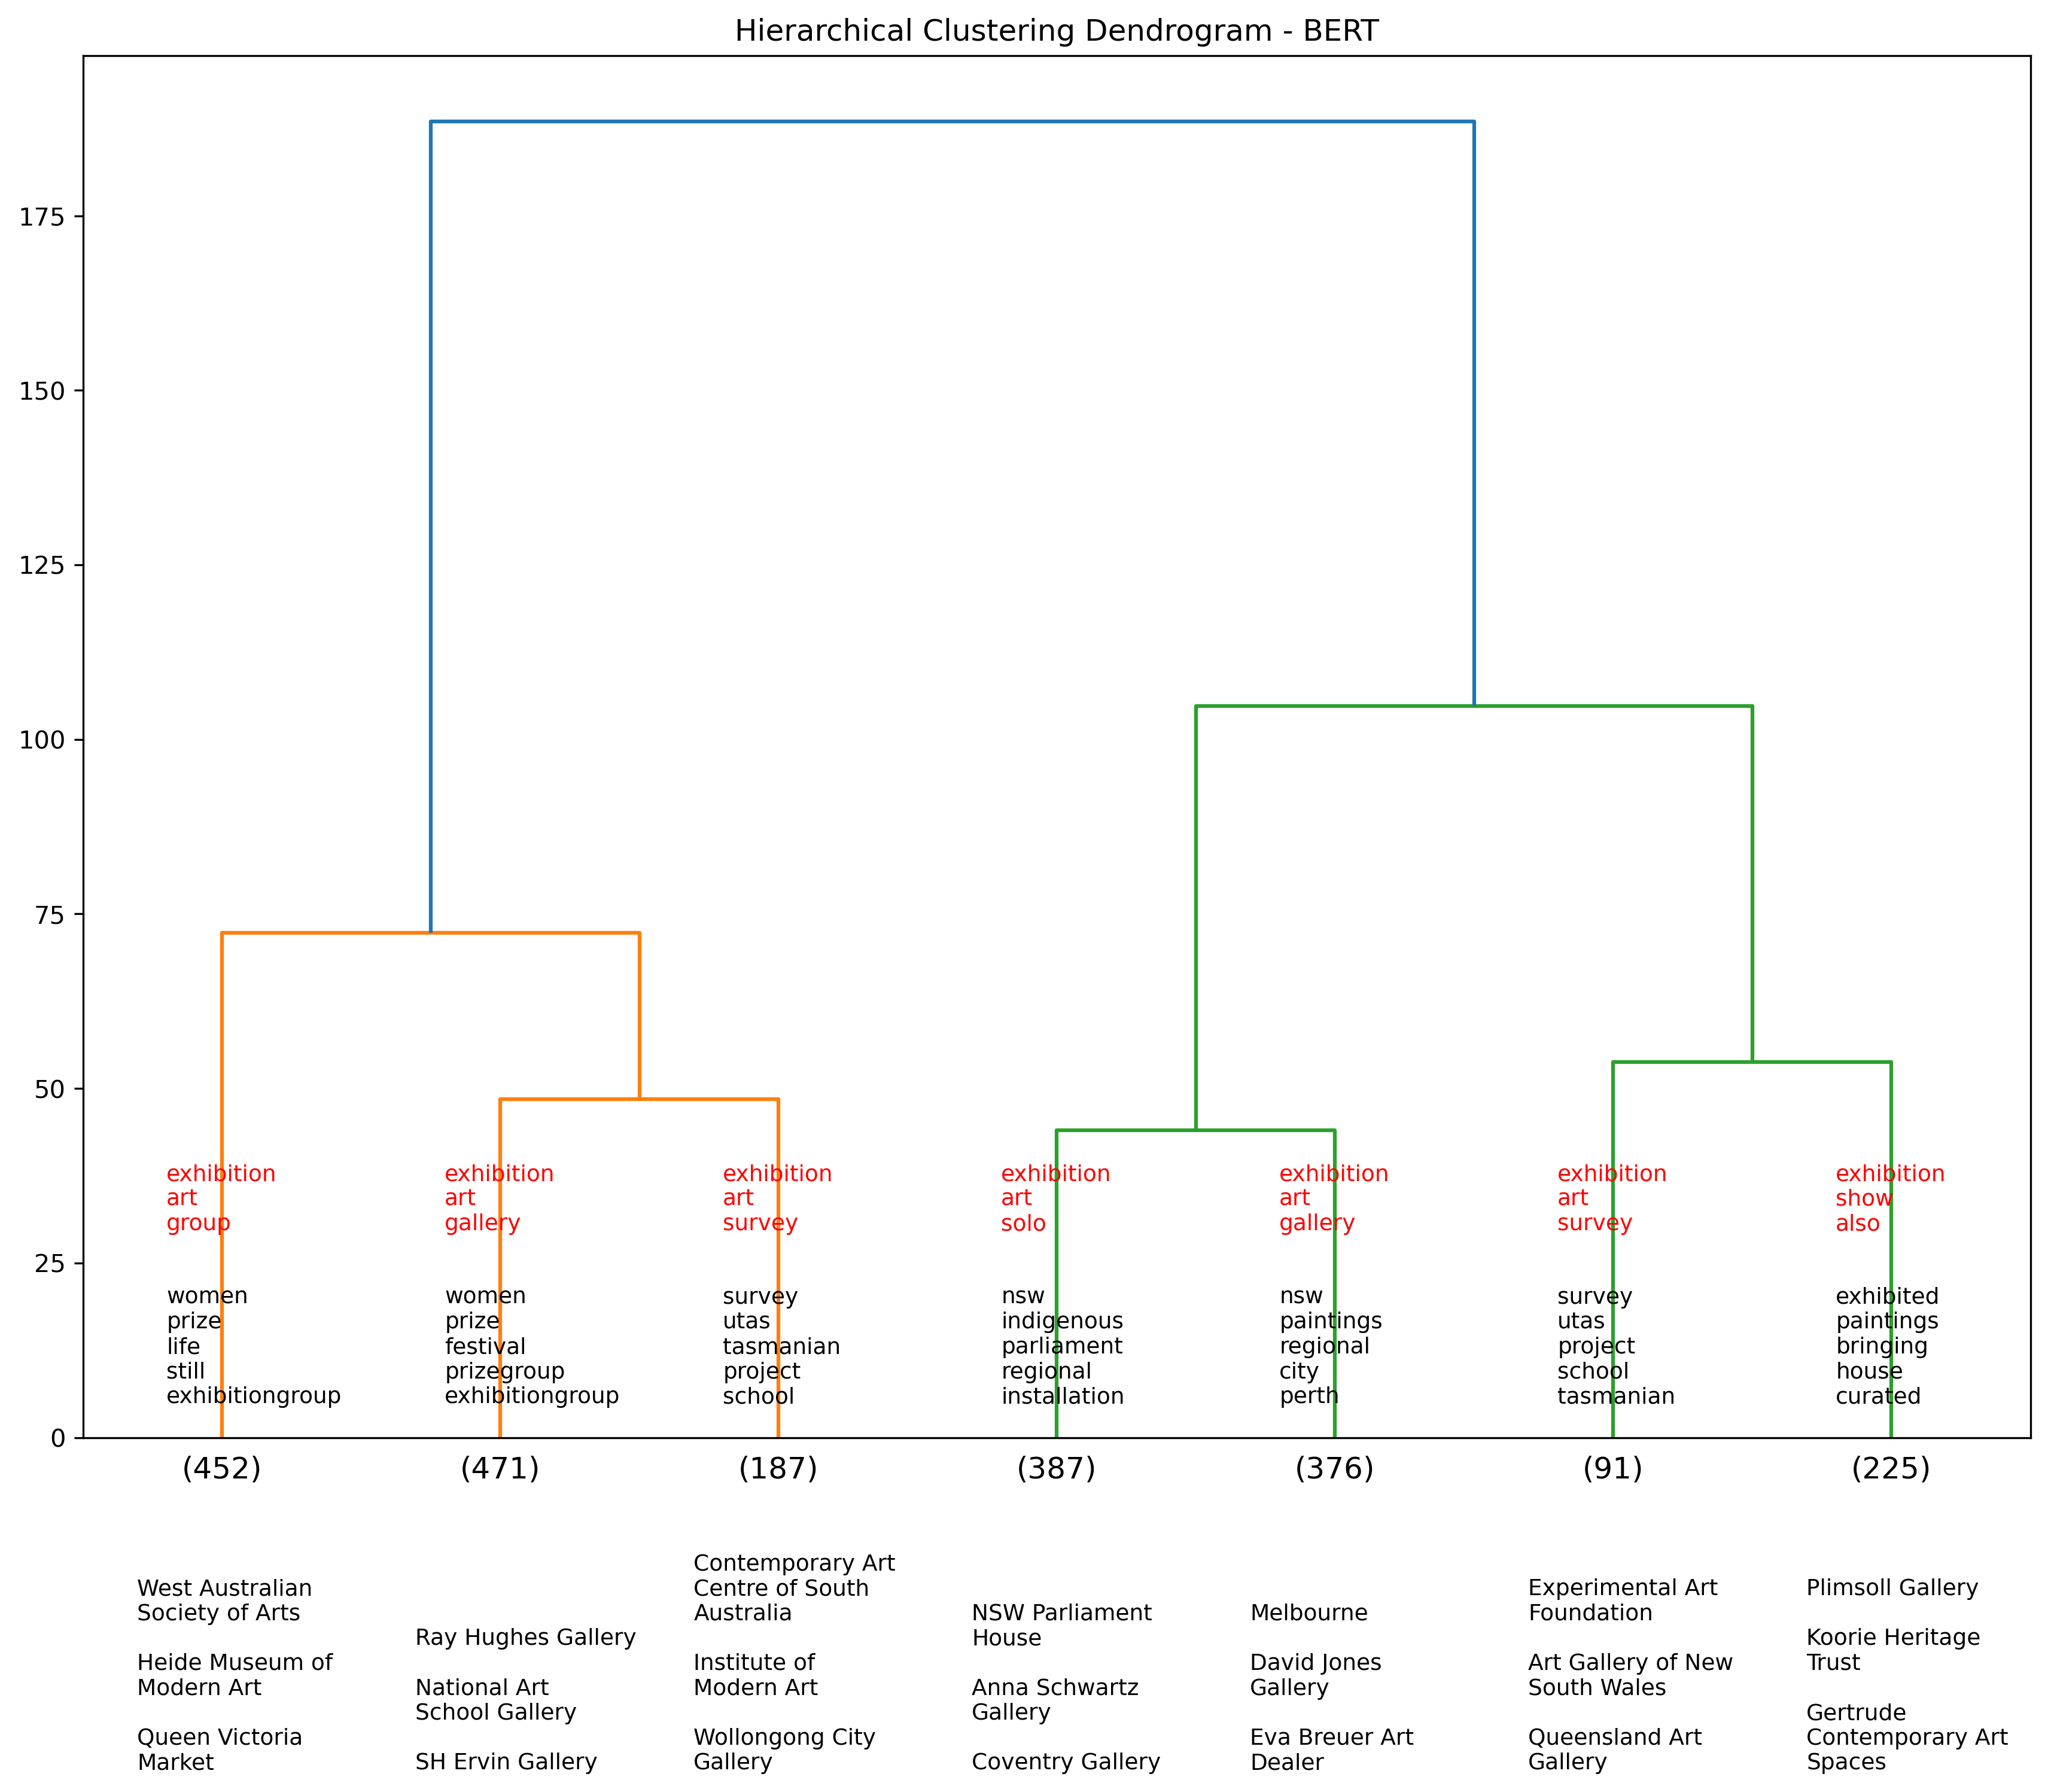

In [153]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))

#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'])) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.15), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.15), 
#                  xycoords='axes fraction', fontsize=9, color='red')

#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=2)
# all_words_to_remove.extend(['j','th','nd','exhibitionexhibited','http','www','isbn'])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.025), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.025), 
#                  xycoords='axes fraction', fontsize=9)
    
#     annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     plt.annotate(annot2, xy=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xytext=(i/df['cluster'].nunique()-0.115, -0.24), 
#                 xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_bert.png', dpi=300, bbox_inches='tight')

from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert.png')

We provide the same visual however show the most frequent terms used within the place names as opposed to the event descriptions.

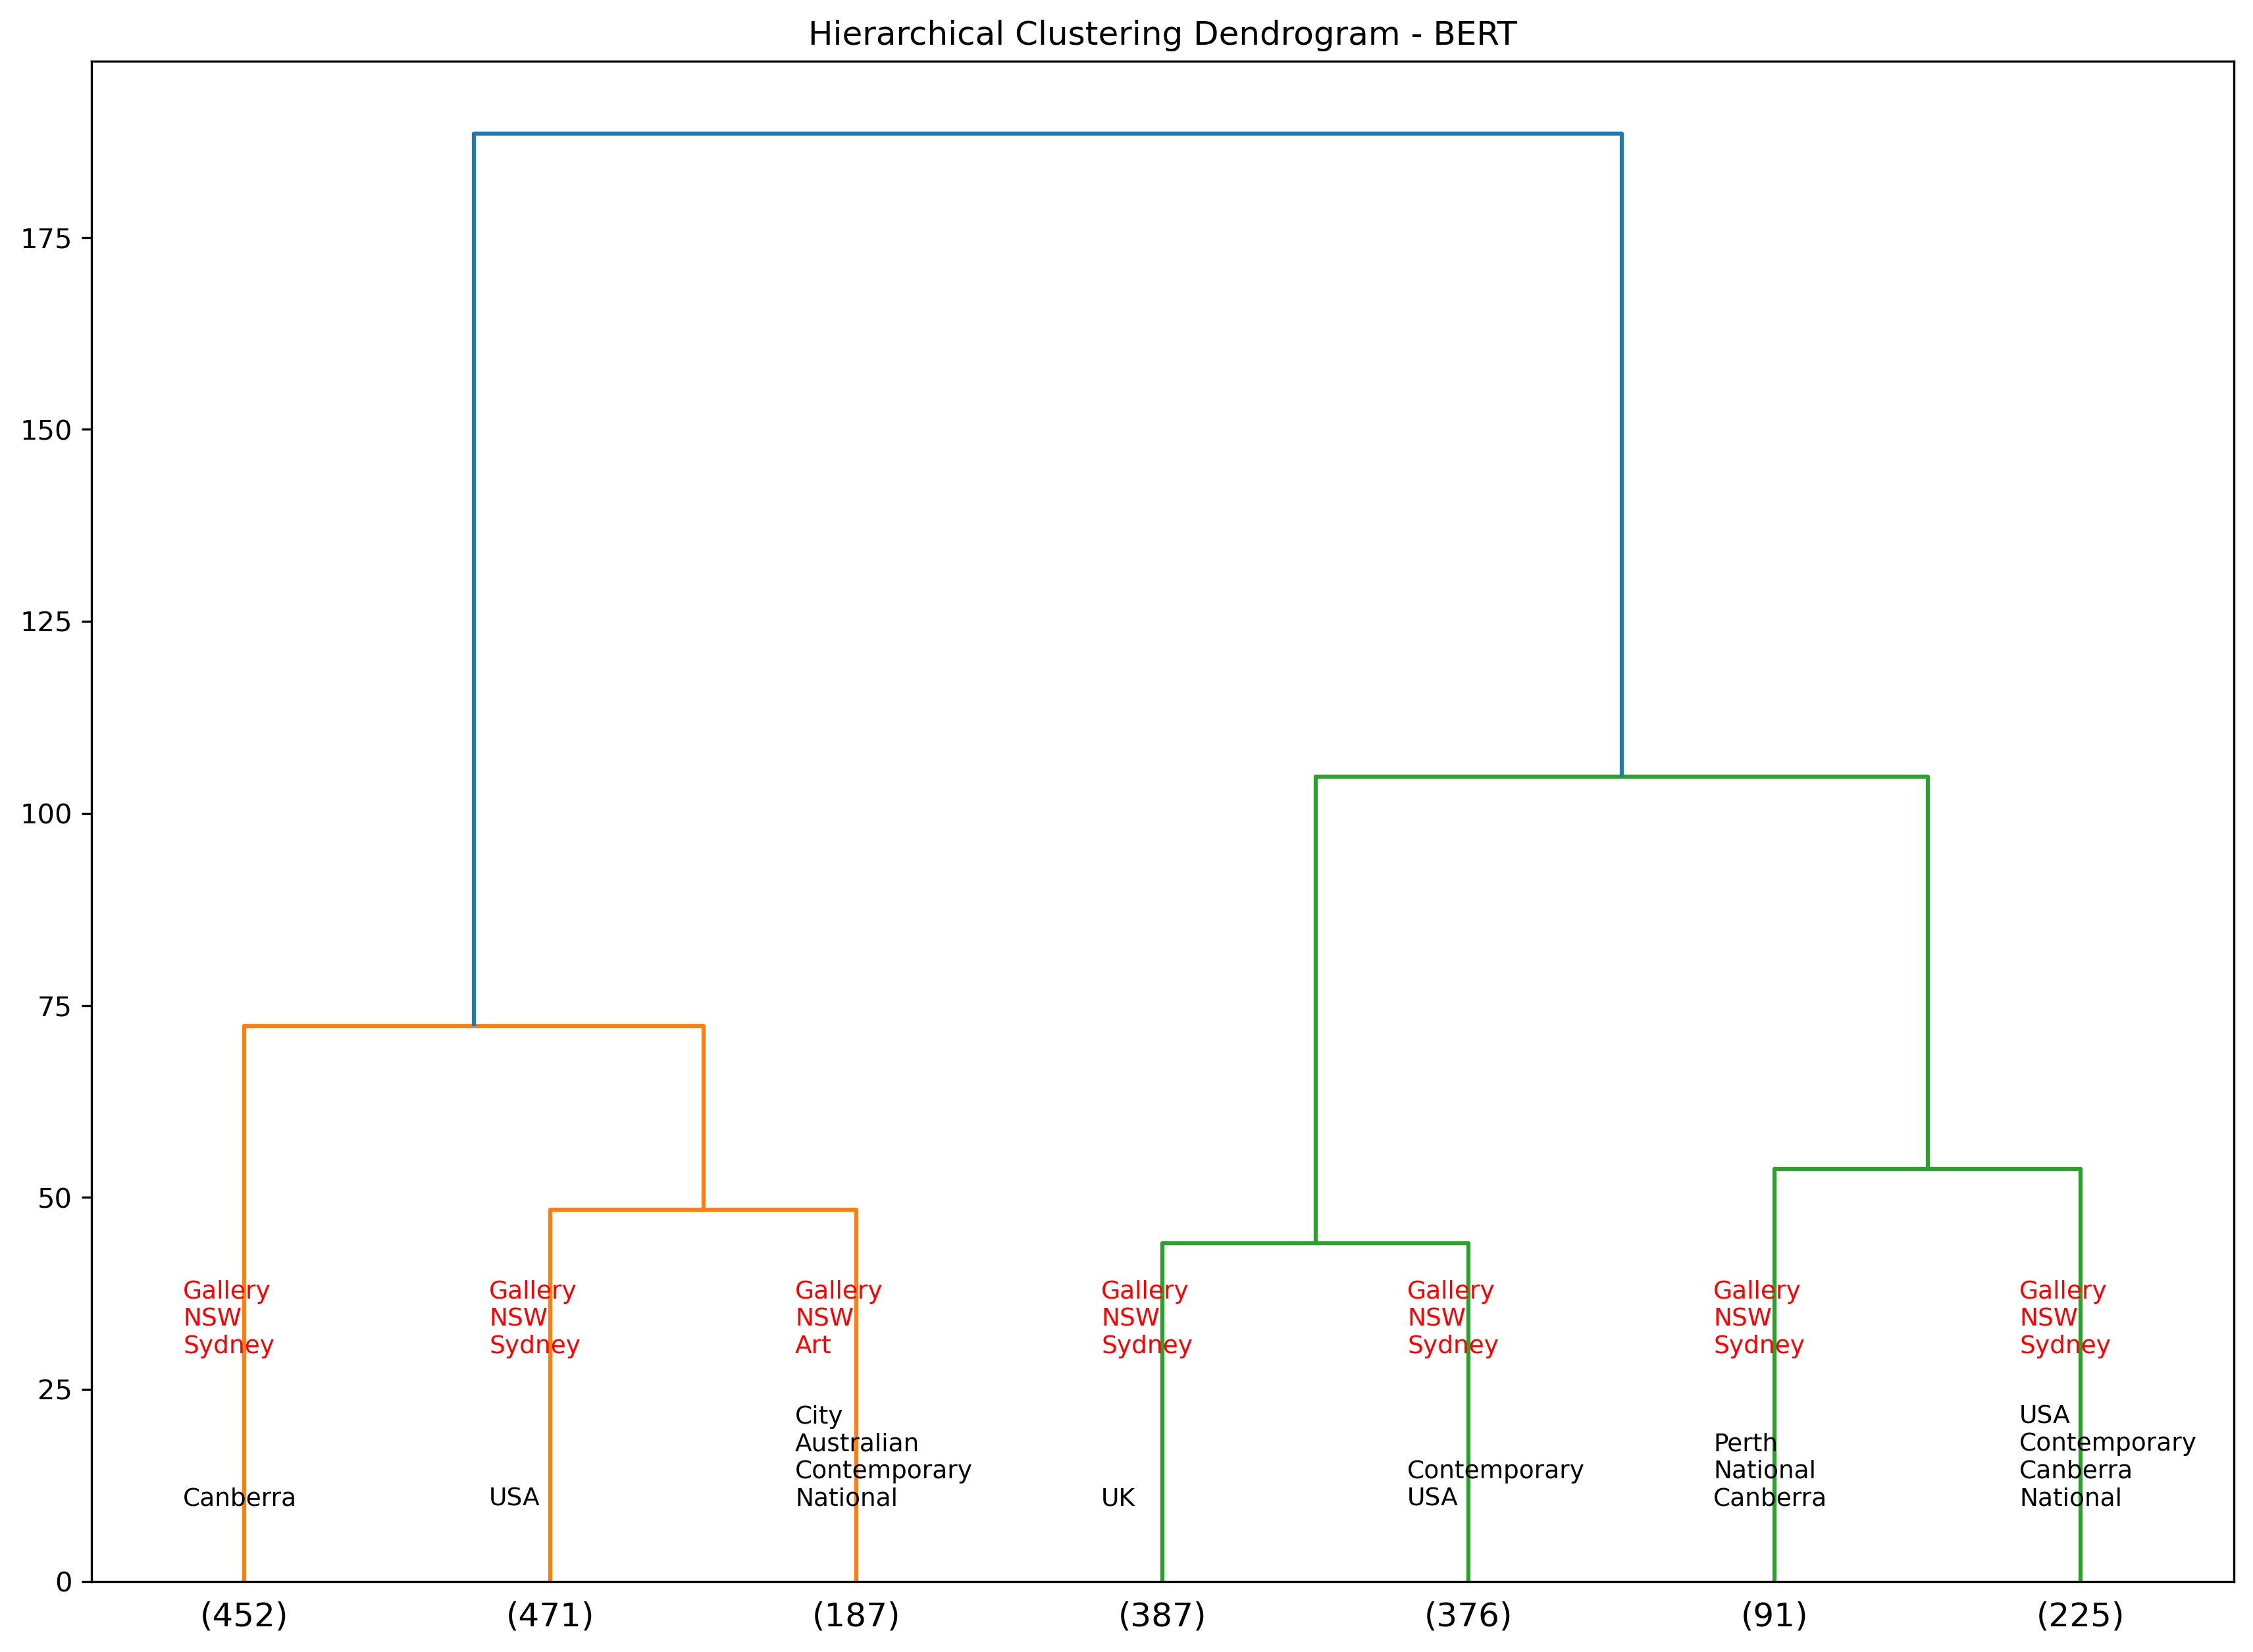

In [157]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert)
# df['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))

#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'])) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.15), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.15), 
#                  xycoords='axes fraction', fontsize=9, color='red')
    
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=25))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=4)
# all_words_to_remove.extend([',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
#                    '.', 'New', 'Australia', 'QLD', 'Vic','and','WA','Victoria','ACT','Qld',
#                    'of','Wollongong','TAS','Queensland','Newcastle',
#                    'Street','Hobart','the','The','Launceston','Orange','NT',
#                    'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
#                    'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
#                    '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
#                    'Curtin','France','Tin','Sheds','York','Monash','Heide',''])

# for i in df['cluster'].unique():
#     cluster_docs = df[df['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_bert_placename.png', dpi=300, bbox_inches='tight')

from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert_placename.png')

### Hierarchical clustering (BERT) after omitting erroneous geocodes that occur frequently

The next two dendograms are the same as above, however we omit the erroneous geocodes that occur frequently (the ones highlighted at the beginning of the notebook).

In [163]:
# # retrieve rows from most_freq_geocodes from a list of indices
# remove_these = most_freq_geocodes.head(20).iloc[most_freq_geocodes.head(20).index.isin([0,1,2,3,10,16])]

# # remove 5656 rows from df_daoo_relevant_events with same lat and long data from remove_these 
# dfs_rich['erroneous'] = np.where(dfs_rich['latitude'].isin(remove_these['latitude']) &\
#                                                 dfs_rich['longitude'].isin(remove_these['longitude']), True, False)

# ### pre-process for NLP
# # Load the documents and their corresponding categorical variables into a Pandas dataframe
# df2 = pd.DataFrame({'text': dfs_rich[dfs_rich['erroneous'] == 0]['slug2'], 
#                    'category': dfs_rich[dfs_rich['erroneous'] == 0]['place_address']})

# # summarise text for each unique place name
# df2['text'] = df2.groupby('category')['text'].transform(lambda x: ' '.join(x))

# #add new column with count for each category
# df2['cat_count'] = df2.groupby('category')['category'].transform('count')
# df2.drop_duplicates(inplace=True)

# # Clean the text
# stop_words = set(stopwords.words('english'))
# df2 = df2[df2['text'].notnull()]
# df2['clean_text'] = df2['text'].apply(clean_text)

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df2['clean_text_sampled'] = df2['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 340)) if len(x.split(' ')) >= 340 else x)
# X_bert2 = df2['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert2 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert2 = model_bert2.fit(np.array(X_bert2))

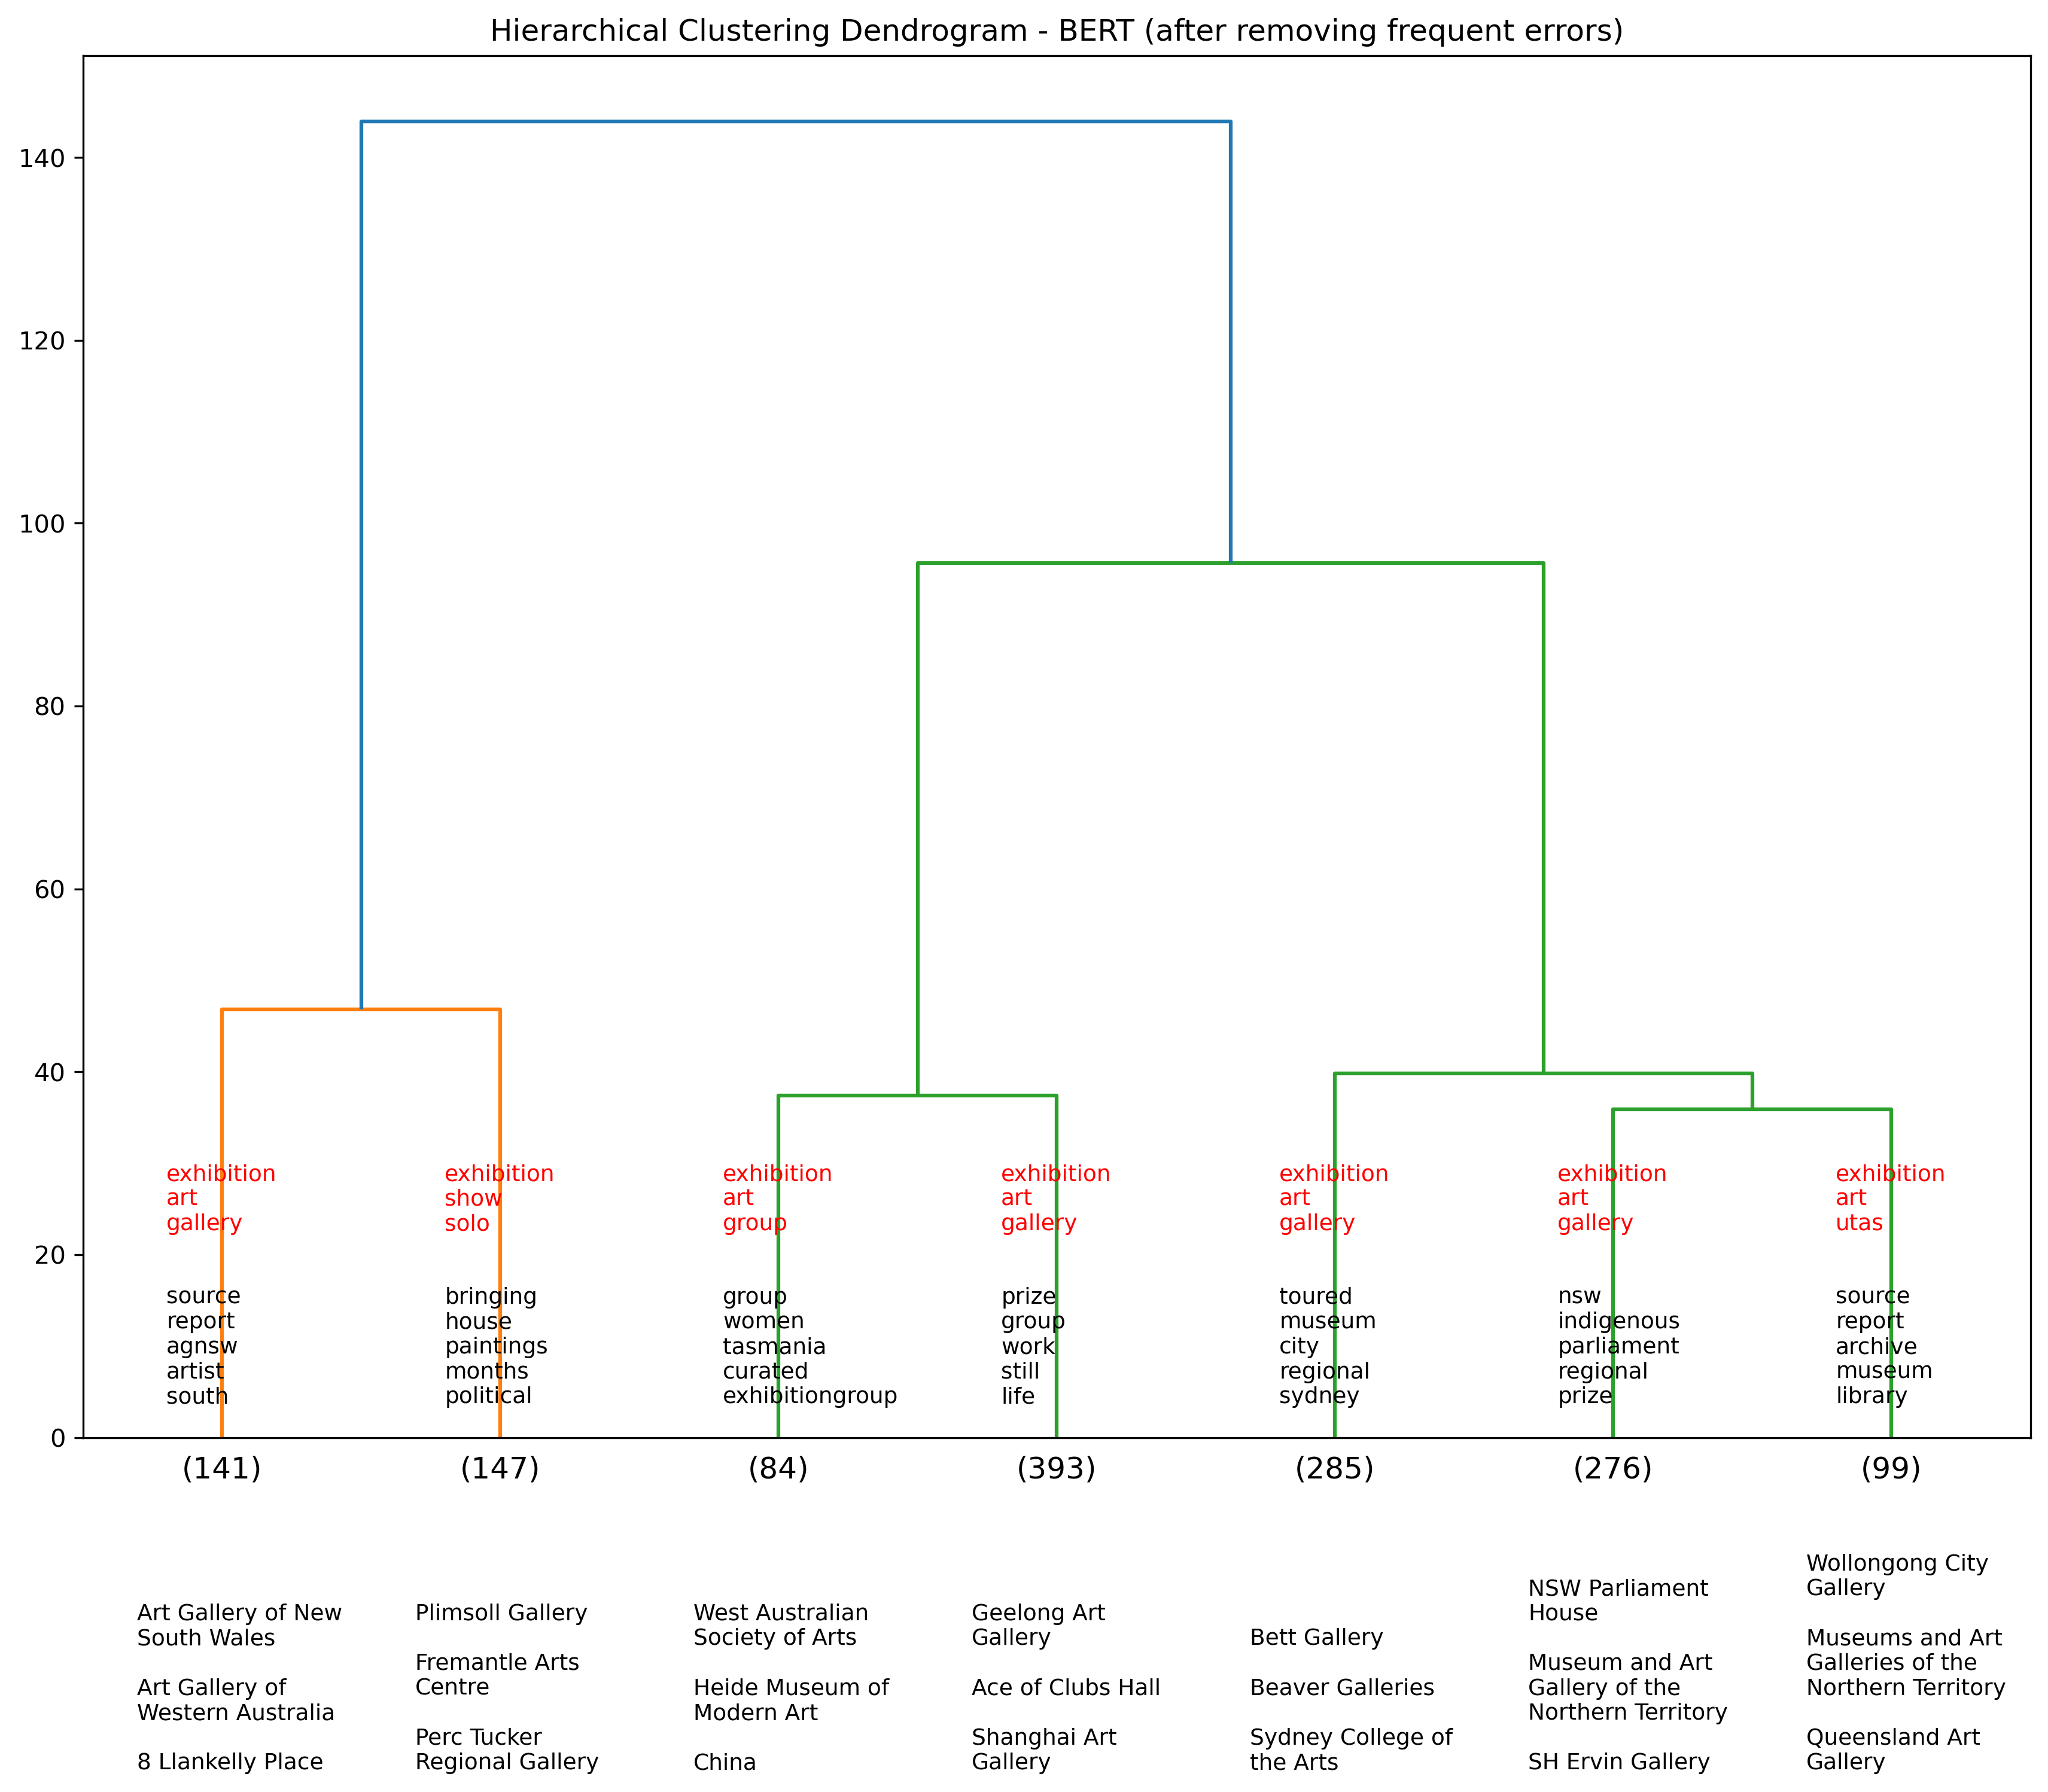

In [168]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert2)
# df2['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))

#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'])) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.15), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.15), 
#                  xycoords='axes fraction', fontsize=9, color='red')
    
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=2)
# all_words_to_remove.extend(['j','p','r','h','c','k','th','nd','exhibitionexhibited','isbn','http','www'])

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
#                                                                        more_words=all_words_to_remove)) if (idx < 5))
    
#     plt.annotate(annot, xy=(i/df2['cluster'].nunique()-0.1, 0.025), 
#                  xytext=(i/df2['cluster'].nunique()-0.1, 0.025), 
#                  xycoords='axes fraction', fontsize=9)
    
#     annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     plt.annotate(annot2, xy=(i/df2['cluster'].nunique()-0.115, -0.24), 
#                 xytext=(i/df2['cluster'].nunique()-0.115, -0.24), 
#                 xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT (after removing frequent errors)")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_bert2.png', dpi=300, bbox_inches='tight')

from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert2.png')

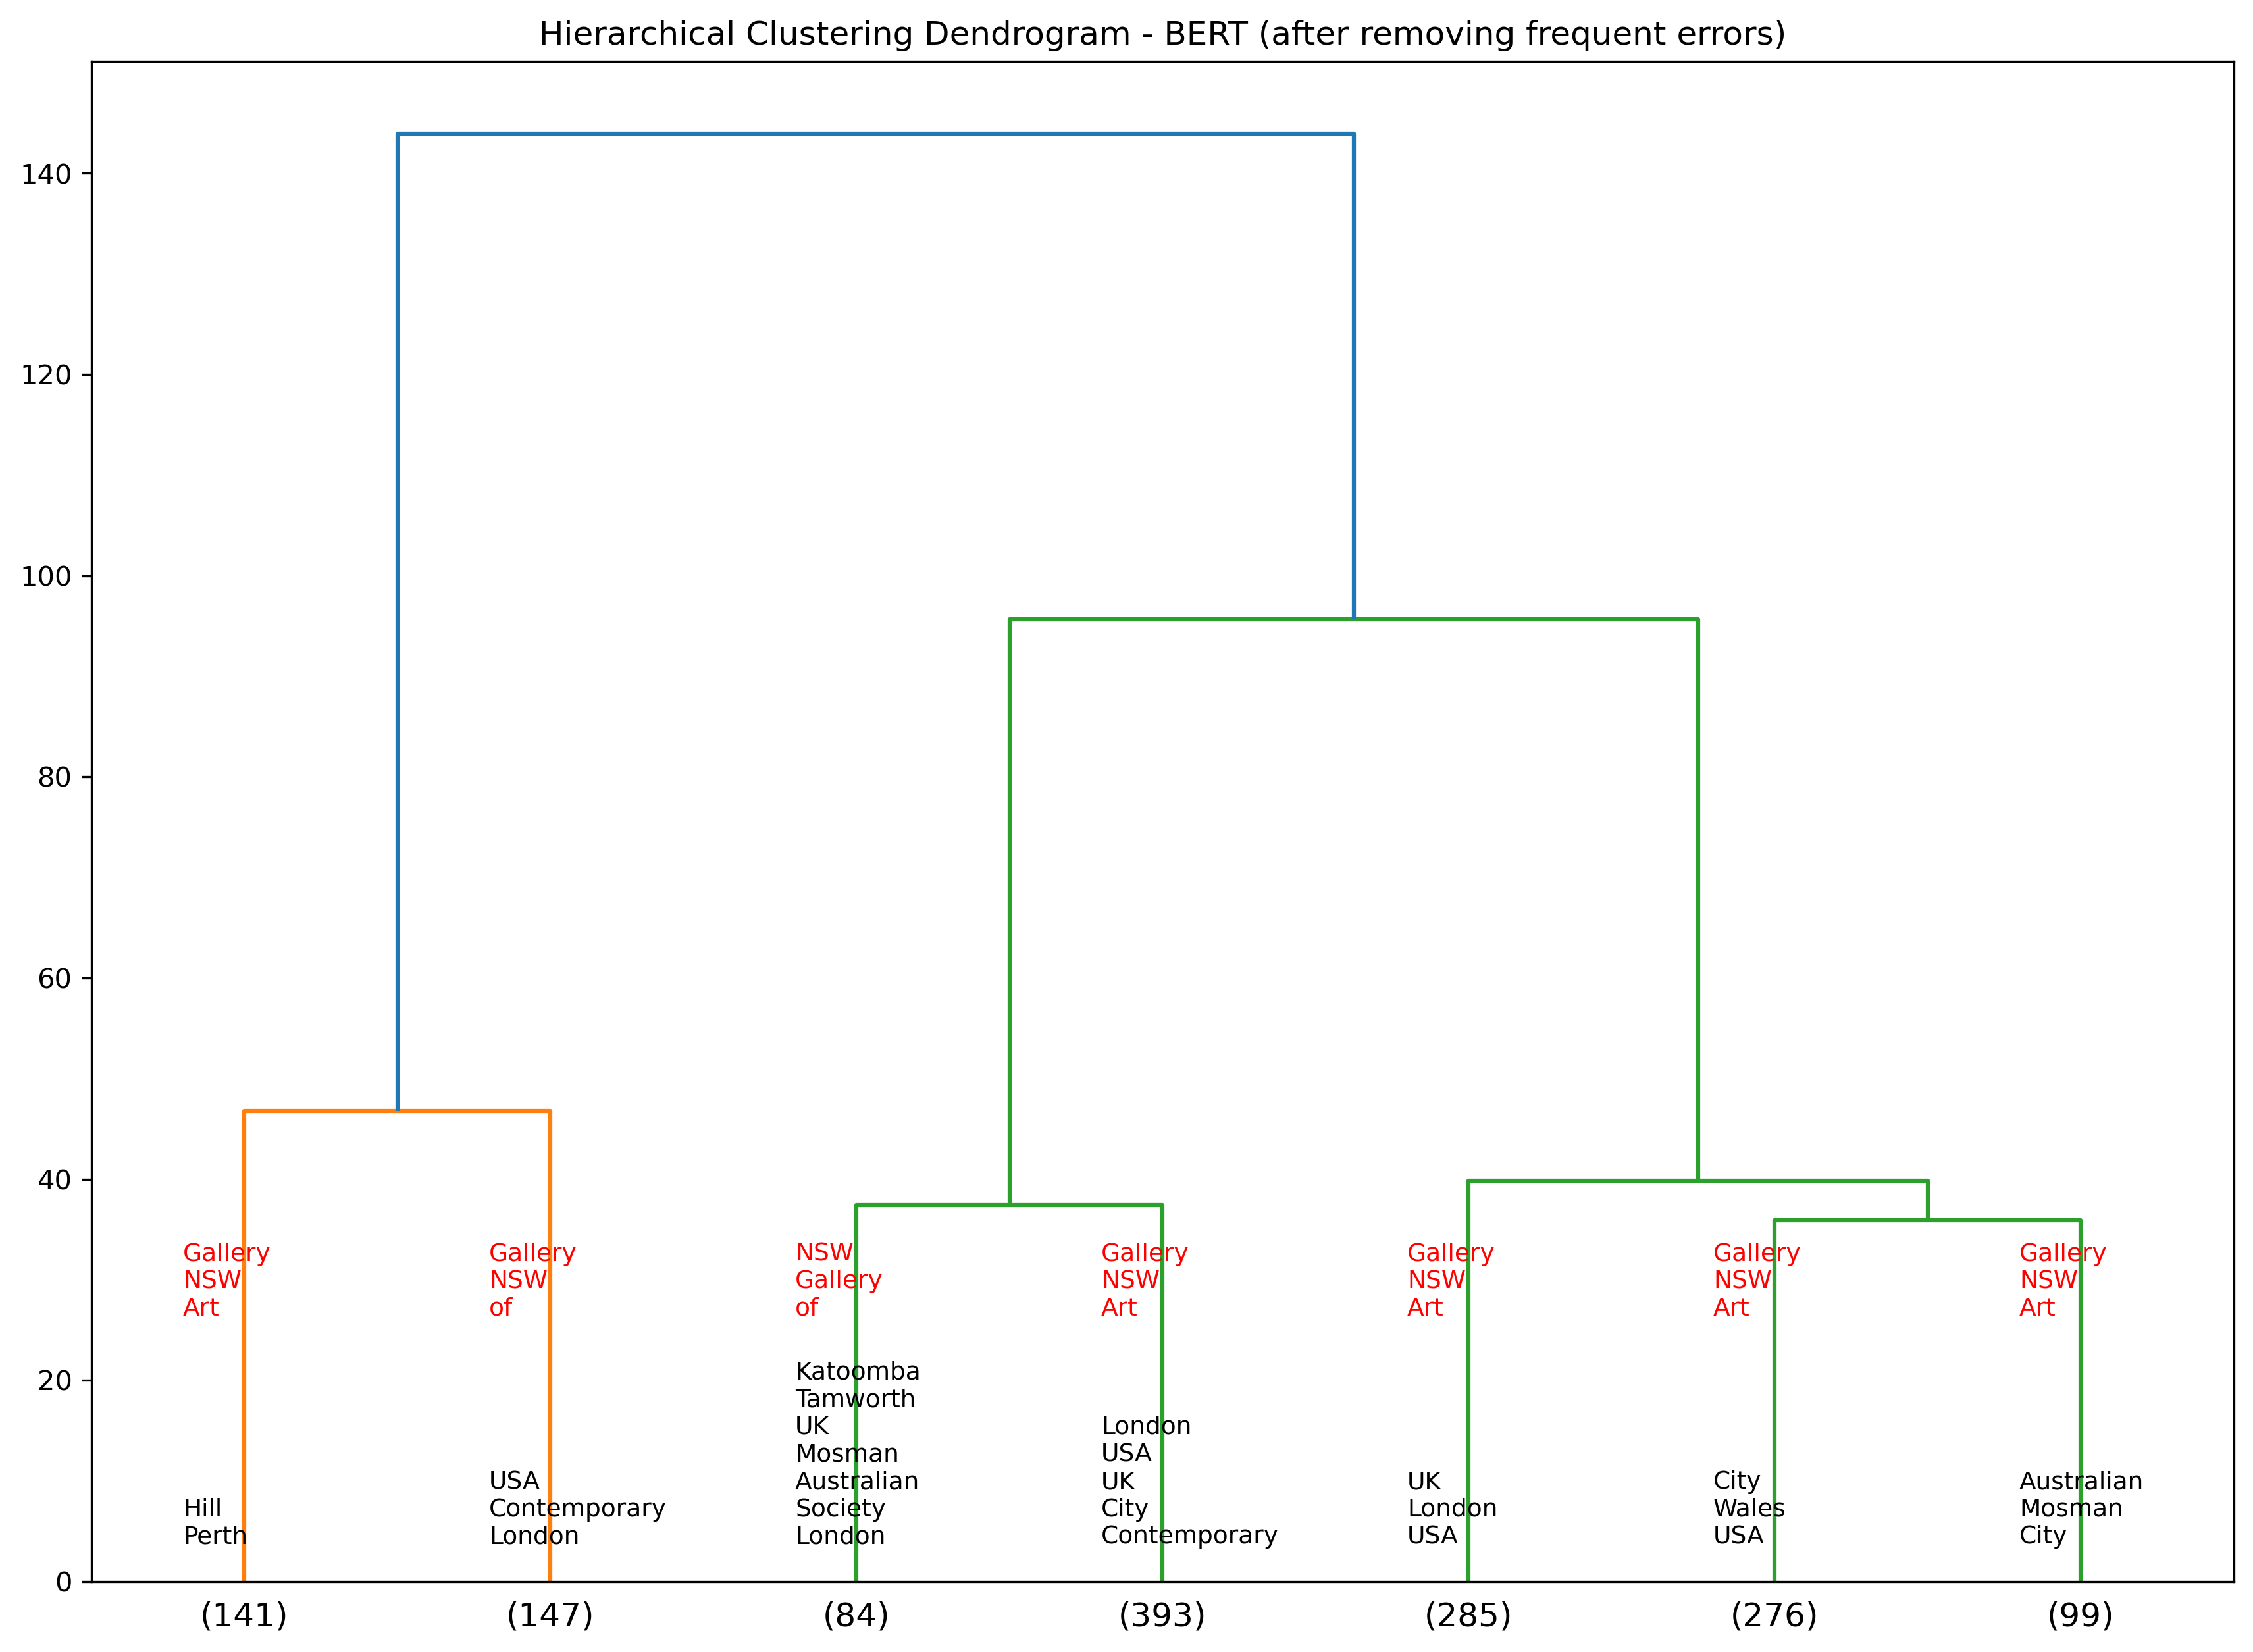

In [175]:
# cut = 7
# l_matrix = get_linkage_matrix(model_bert2)
# df2['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))

#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'])) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df['cluster'].nunique()-0.1, 0.175), 
#                  xytext=(i/df['cluster'].nunique()-0.1, 0.175), 
#                  xycoords='axes fraction', fontsize=9, color='red')

#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=30))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=5)
# all_words_to_remove.extend([',','NSW','Sydney','Melbourne','Adelaide','South','SA','Brisbane','VIC',
#                    '.', 'New', 'QLD', 'Vic','and','WA','Victoria','ACT','Qld',
#                    'of','Wollongong','TAS','Queensland','Newcastle','Australia',
#                    'Street','Hobart','the','The','Launceston','Orange','NT',
#                    'Paddington','Darwin','for','Western','Warrnambool','Ballarat','Northern','Territory',
#                    'England','Watters','Macquarie','Artspace','St',"'s",'&','Potter','Kings','Ian','Cross',
#                    '8','Llankelly','2011','Fremantle','Queen','Ivan','Dougherty','Tasmania','Central',
#                    'Curtin','France','Tin','Sheds','York','Monash','Heide',''])

# for i in df2['cluster'].unique():
#     cluster_docs = df2[df2['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'],
#                                                                        more_words=all_words_to_remove)) if (idx < 20))
    
#     plt.annotate(annot, xy=(i/df2['cluster'].nunique()-0.1, 0.025), 
#                  xytext=(i/df2['cluster'].nunique()-0.1, 0.025), 
#                  xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT (after removing frequent errors)")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

# # save the figure
# fig.savefig('images/daao_tlc/outputnew_bert2_placename.png', dpi=300, bbox_inches='tight')

from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert2_placename.png')

### Hierarchy Clustering - BERT by vicennium

Using the BERT model, we generate a series of dendrograms that show the hierarchical clustering of the exhibition descriptions by 20-year periods.

#### 1900 - 1920

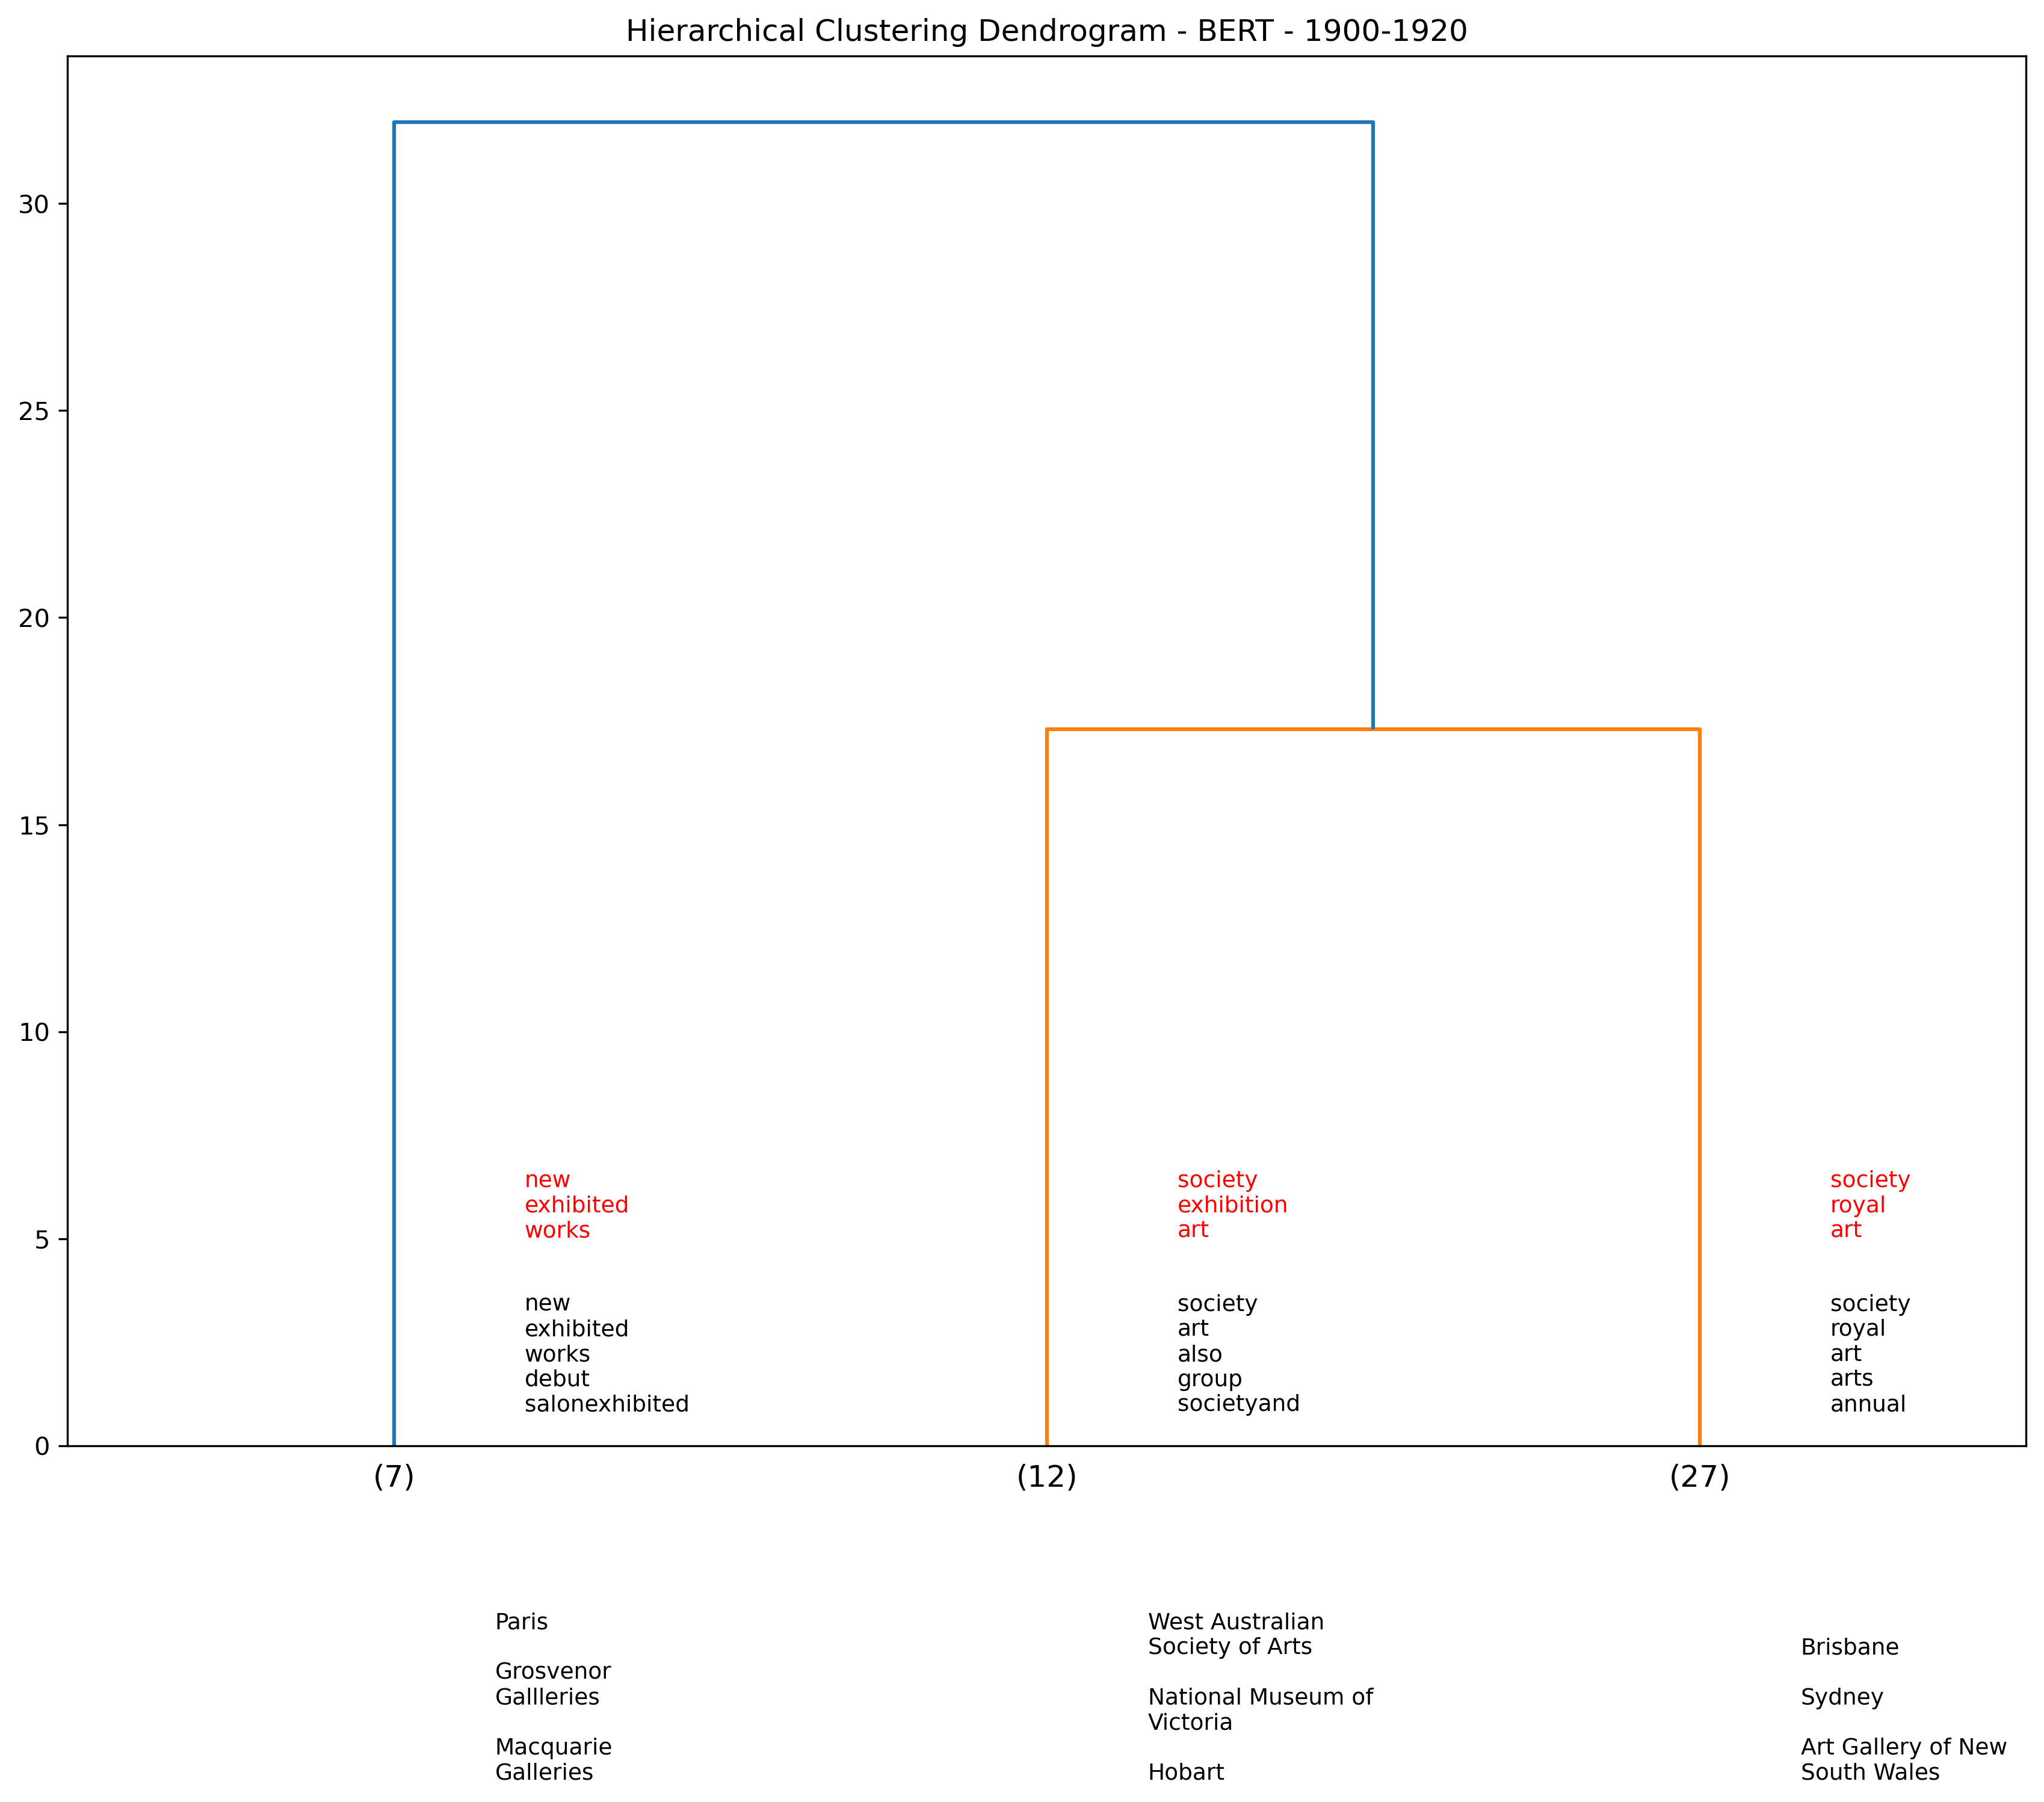

In [201]:
def temporal_dendos(startdt=1900, enddt=1920, cut_input=3):
    df_period = dfs_rich[(dfs_rich['decade_start'] >= startdt) & (dfs_rich['decade_start'] <= enddt)]
    ### pre-process for NLP
    # Load the documents and their corresponding categorical variables into a Pandas dataframe
    df_period = pd.DataFrame({'text': df_period['slug2'], 'category': df_period['place_address']})

    # summarise text for each unique place name
    df_period['text'] = df_period.groupby('category')['text'].transform(lambda x: ' '.join(x))

    #add new column with count for each category
    df_period['cat_count'] = df_period.groupby('category')['category'].transform('count')
    df_period.drop_duplicates(inplace=True)

    # Clean the text
    stop_words = set(stopwords.words('english'))
    df_period = df_period[df_period['text'].notnull()]
    df_period['clean_text'] = df_period['text'].apply(clean_text)

    # randomly sample 512 tokens from each row in df['clean_text']
    # some strings are smalle than 512
    df_period['clean_text_sampled'] = df_period['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 300)) if len(x.split(' ')) >= 300 else x)
    X_bert_period = df_period['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

    # setting distance_threshold=0 ensures we compute the full tree.
    model_bert_period = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model_bert_period = model_bert_period.fit(np.array(X_bert_period))

    ### generate dendrogram
    cut = cut_input
    l_matrix = get_linkage_matrix(model_bert_period)
    df_period['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
    dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

    all_words = []

    for i in df_period['cluster'].unique():
        cluster_docs = df_period[df_period['cluster'] == i]
        # print(i, get_most_common_word(cluster_docs['clean_text']))

        annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'])) if (idx < 3))
        
        plt.annotate(annot, xy=(i/df_period['cluster'].nunique()-0.1, 0.15), 
                    xytext=(i/df_period['cluster'].nunique()-0.1, 0.15), 
                    xycoords='axes fraction', fontsize=9, color='red')

        [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text']))]
        
    all_words_to_remove = find_duplicates(all_words, occurences=2)
    all_words_to_remove.extend(['j','th','nd','exhibitionexhibited','http','www','isbn'])

    for i in df_period['cluster'].unique():
        cluster_docs = df_period[df_period['cluster'] == i]
        # print(i, get_most_common_word(cluster_docs['clean_text']))
        annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['clean_text'],
                                                                        more_words=all_words_to_remove)) if (idx < 5))
        
        plt.annotate(annot, xy=(i/df_period['cluster'].nunique()-0.1, 0.025), 
                    xytext=(i/df_period['cluster'].nunique()-0.1, 0.025), 
                    xycoords='axes fraction', fontsize=9)
        
        annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
        annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
        # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

        plt.annotate(annot2, xy=(i/df_period['cluster'].nunique()-0.115, -0.24), 
                    xytext=(i/df_period['cluster'].nunique()-0.115, -0.24), 
                    xycoords='axes fraction', fontsize=9)

    plt.title(f"Hierarchical Clustering Dendrogram - BERT - {startdt}-{enddt}")

    # make figure bigger
    fig = plt.gcf()
    fig.set_size_inches(14, 10)

    plt.show()

    # save the figure
    fig.savefig(f'images/daao_tlc/outputnew_bert_{startdt}_{enddt}.png', dpi=300, bbox_inches='tight')
# temporal_dendos(2000, 2030, cut_input=5)

from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert_1900_1920.png')

#### 1920 - 1940

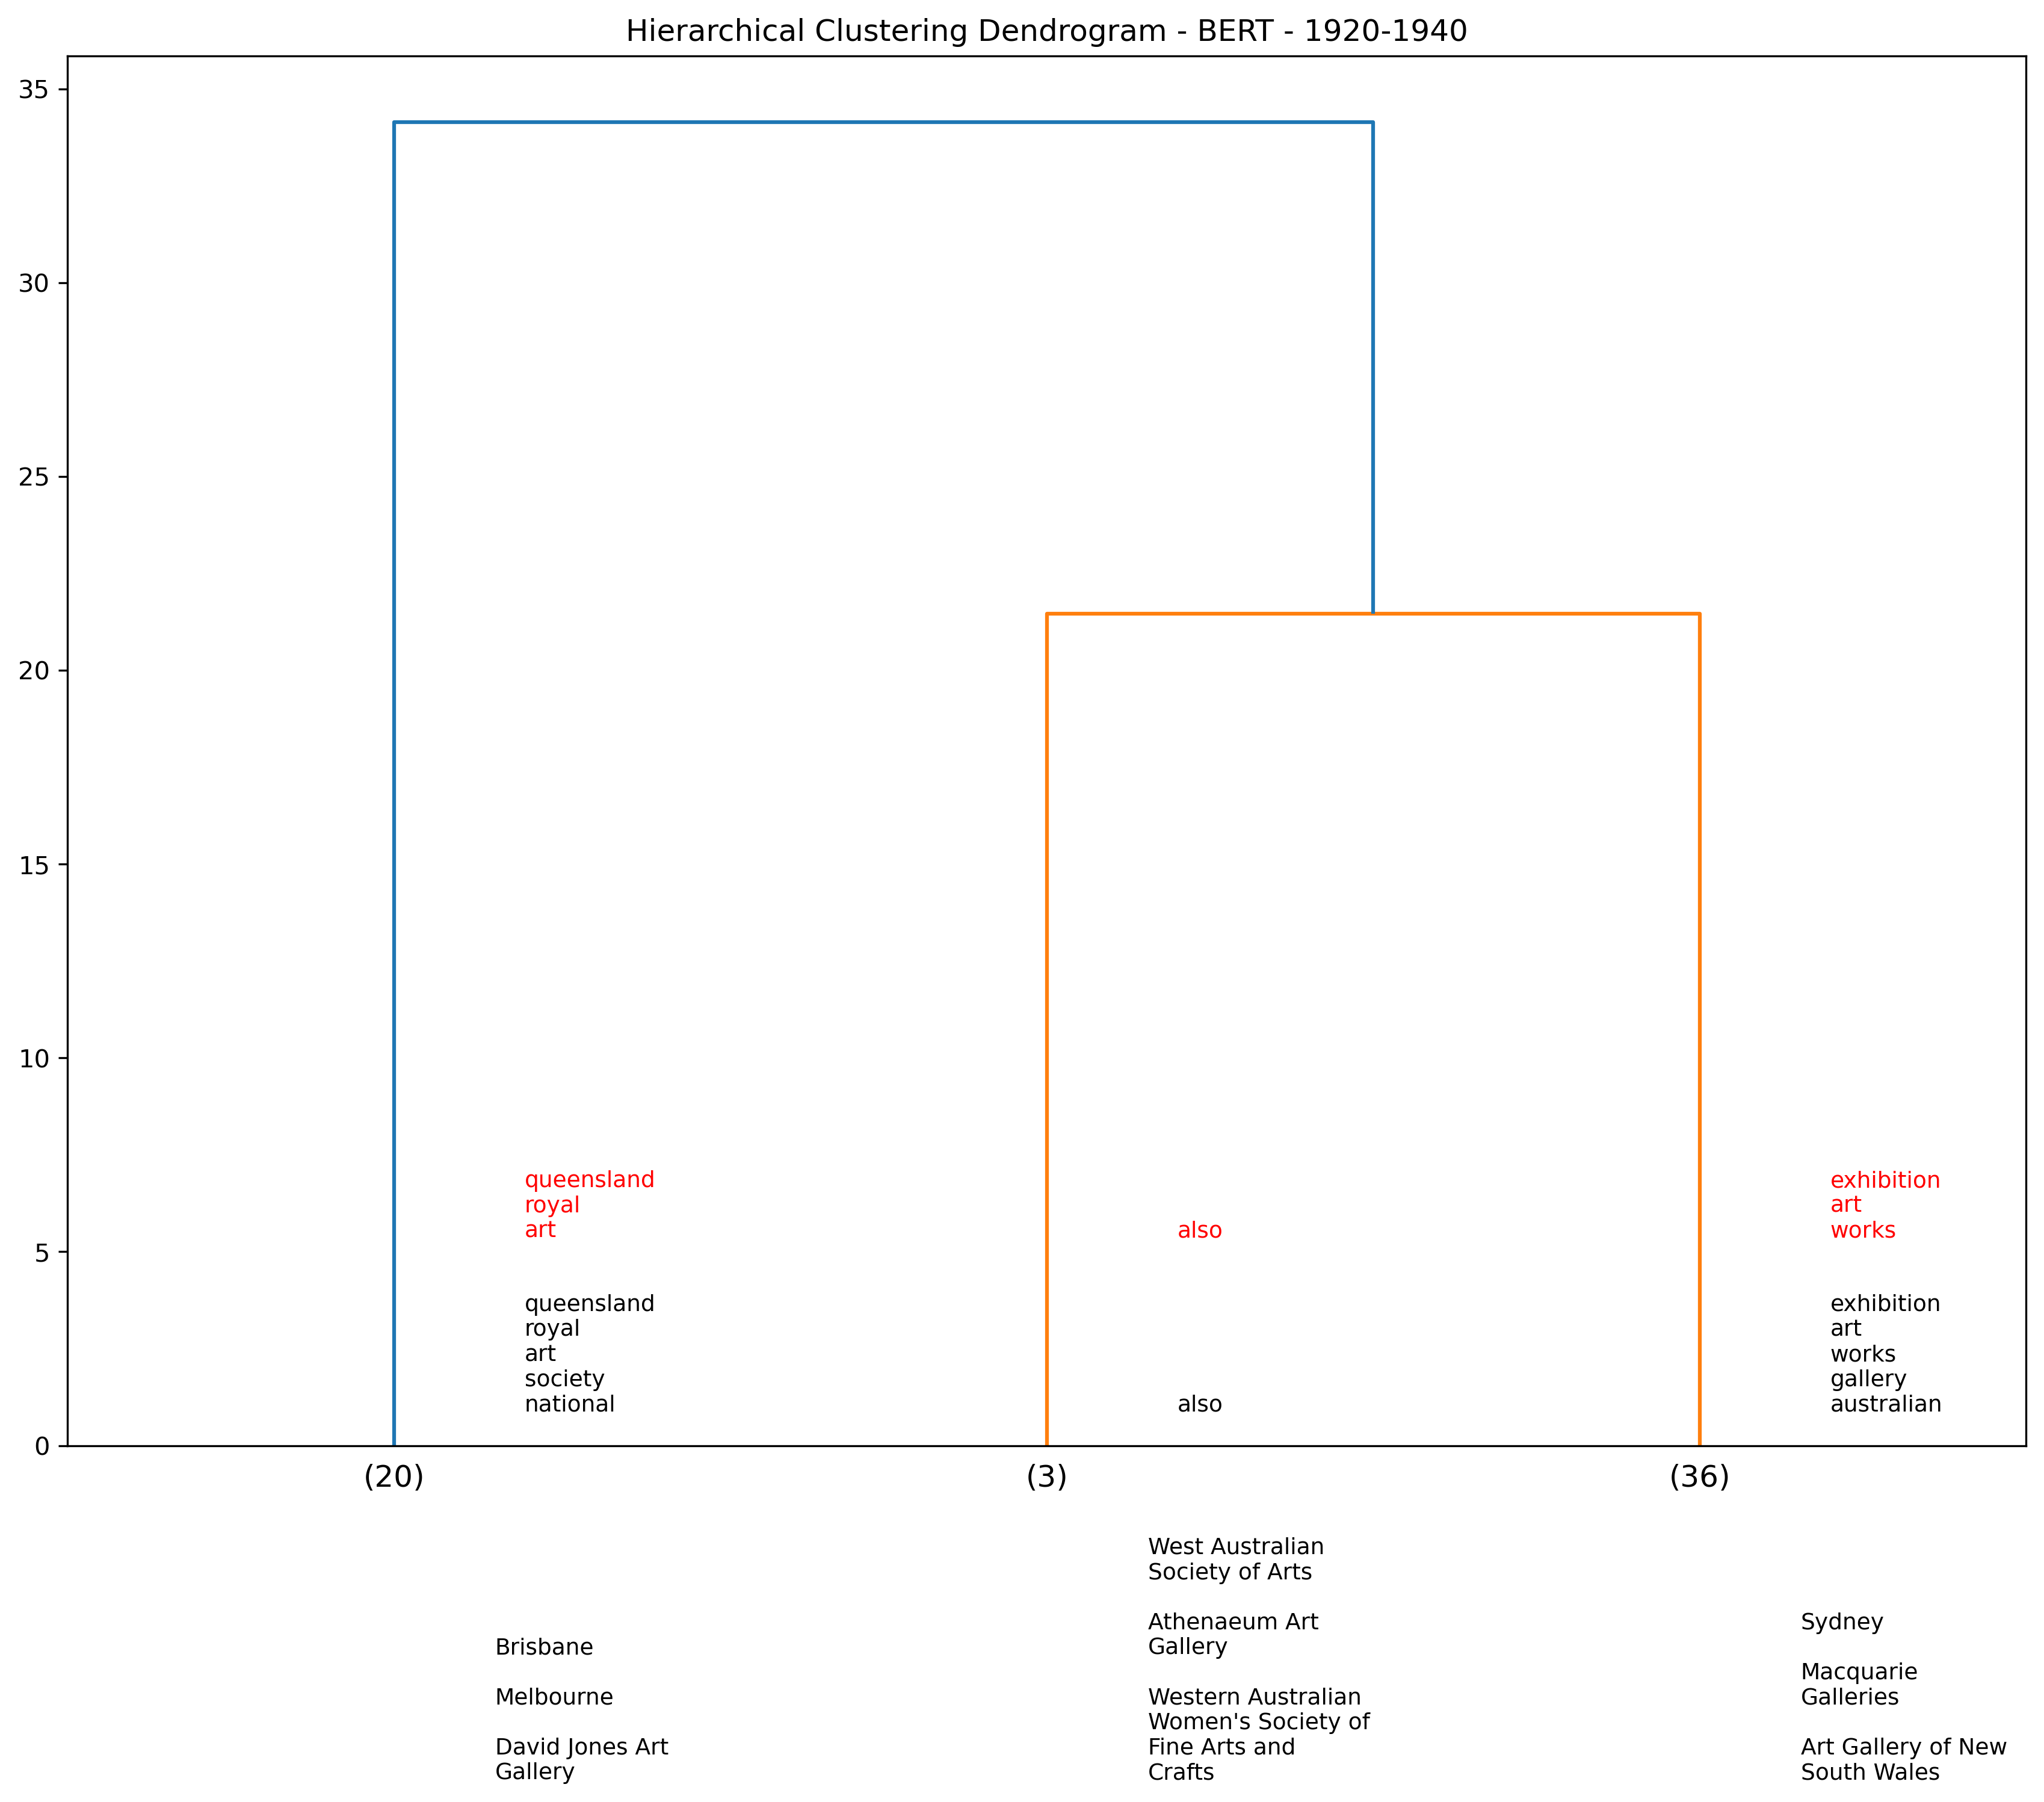

In [202]:
from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert_1920_1940.png')

#### 1940 - 1960

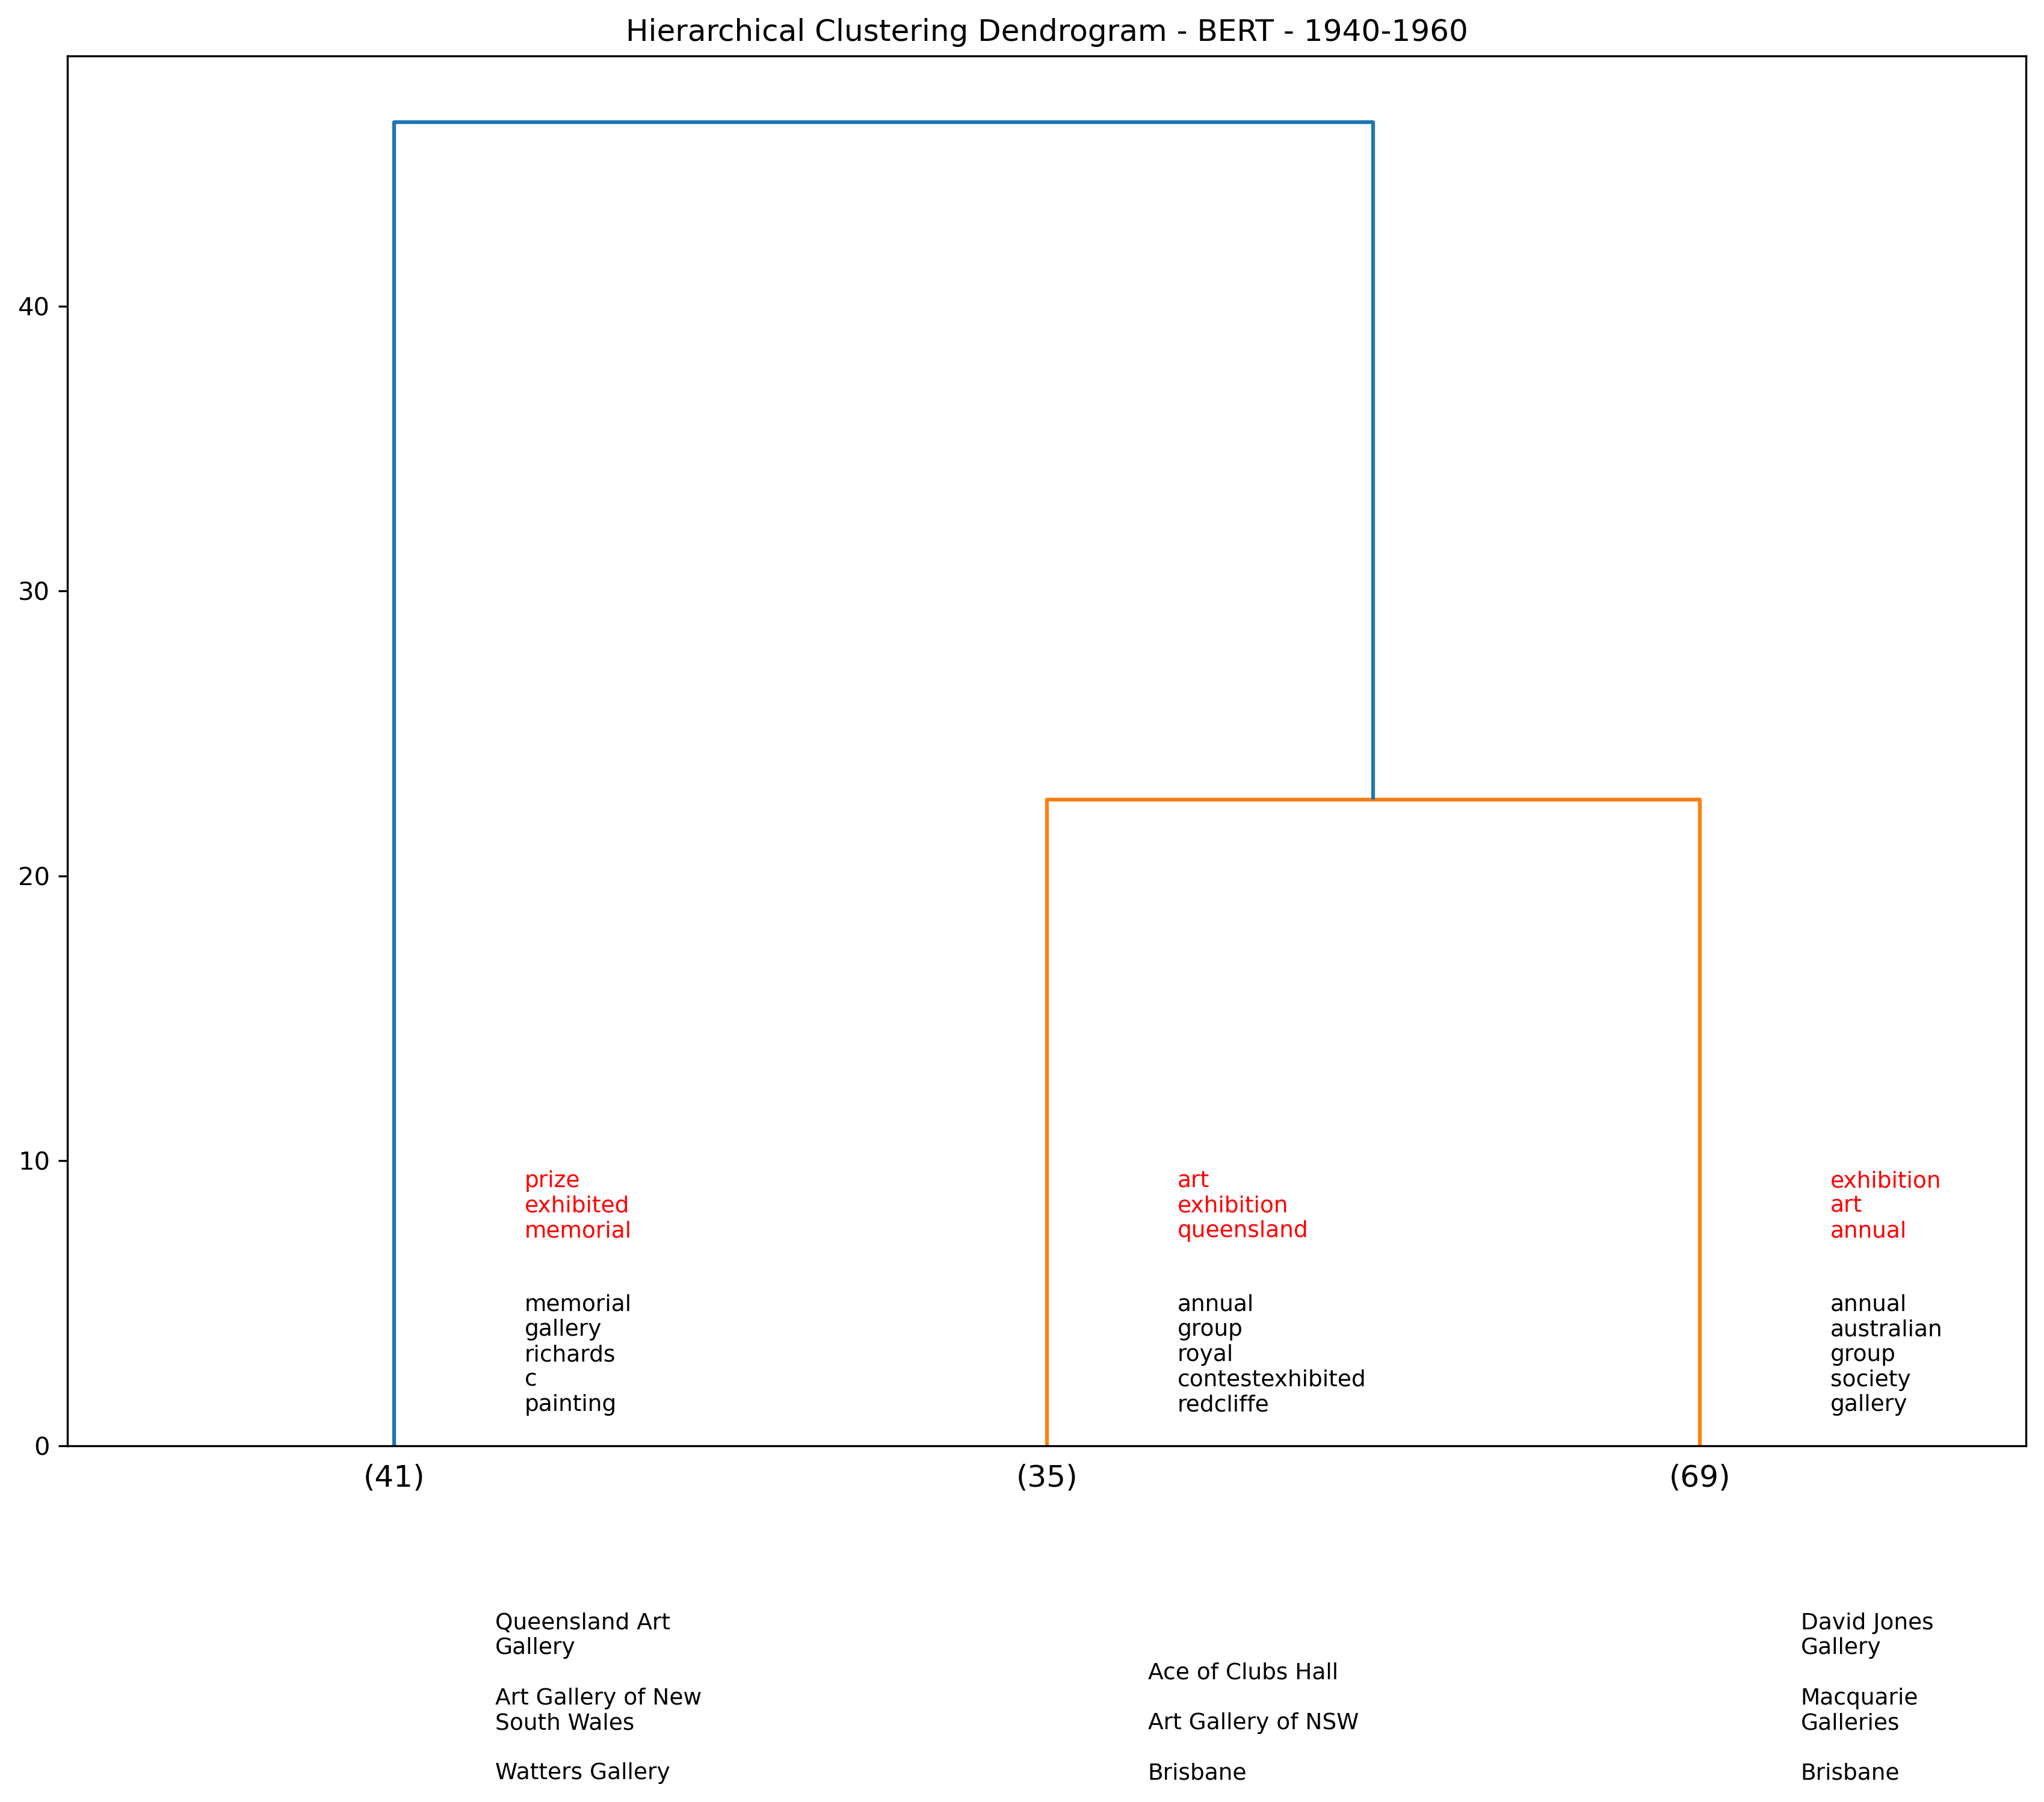

In [203]:
from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert_1940_1960.png')

#### 1960 - 1980

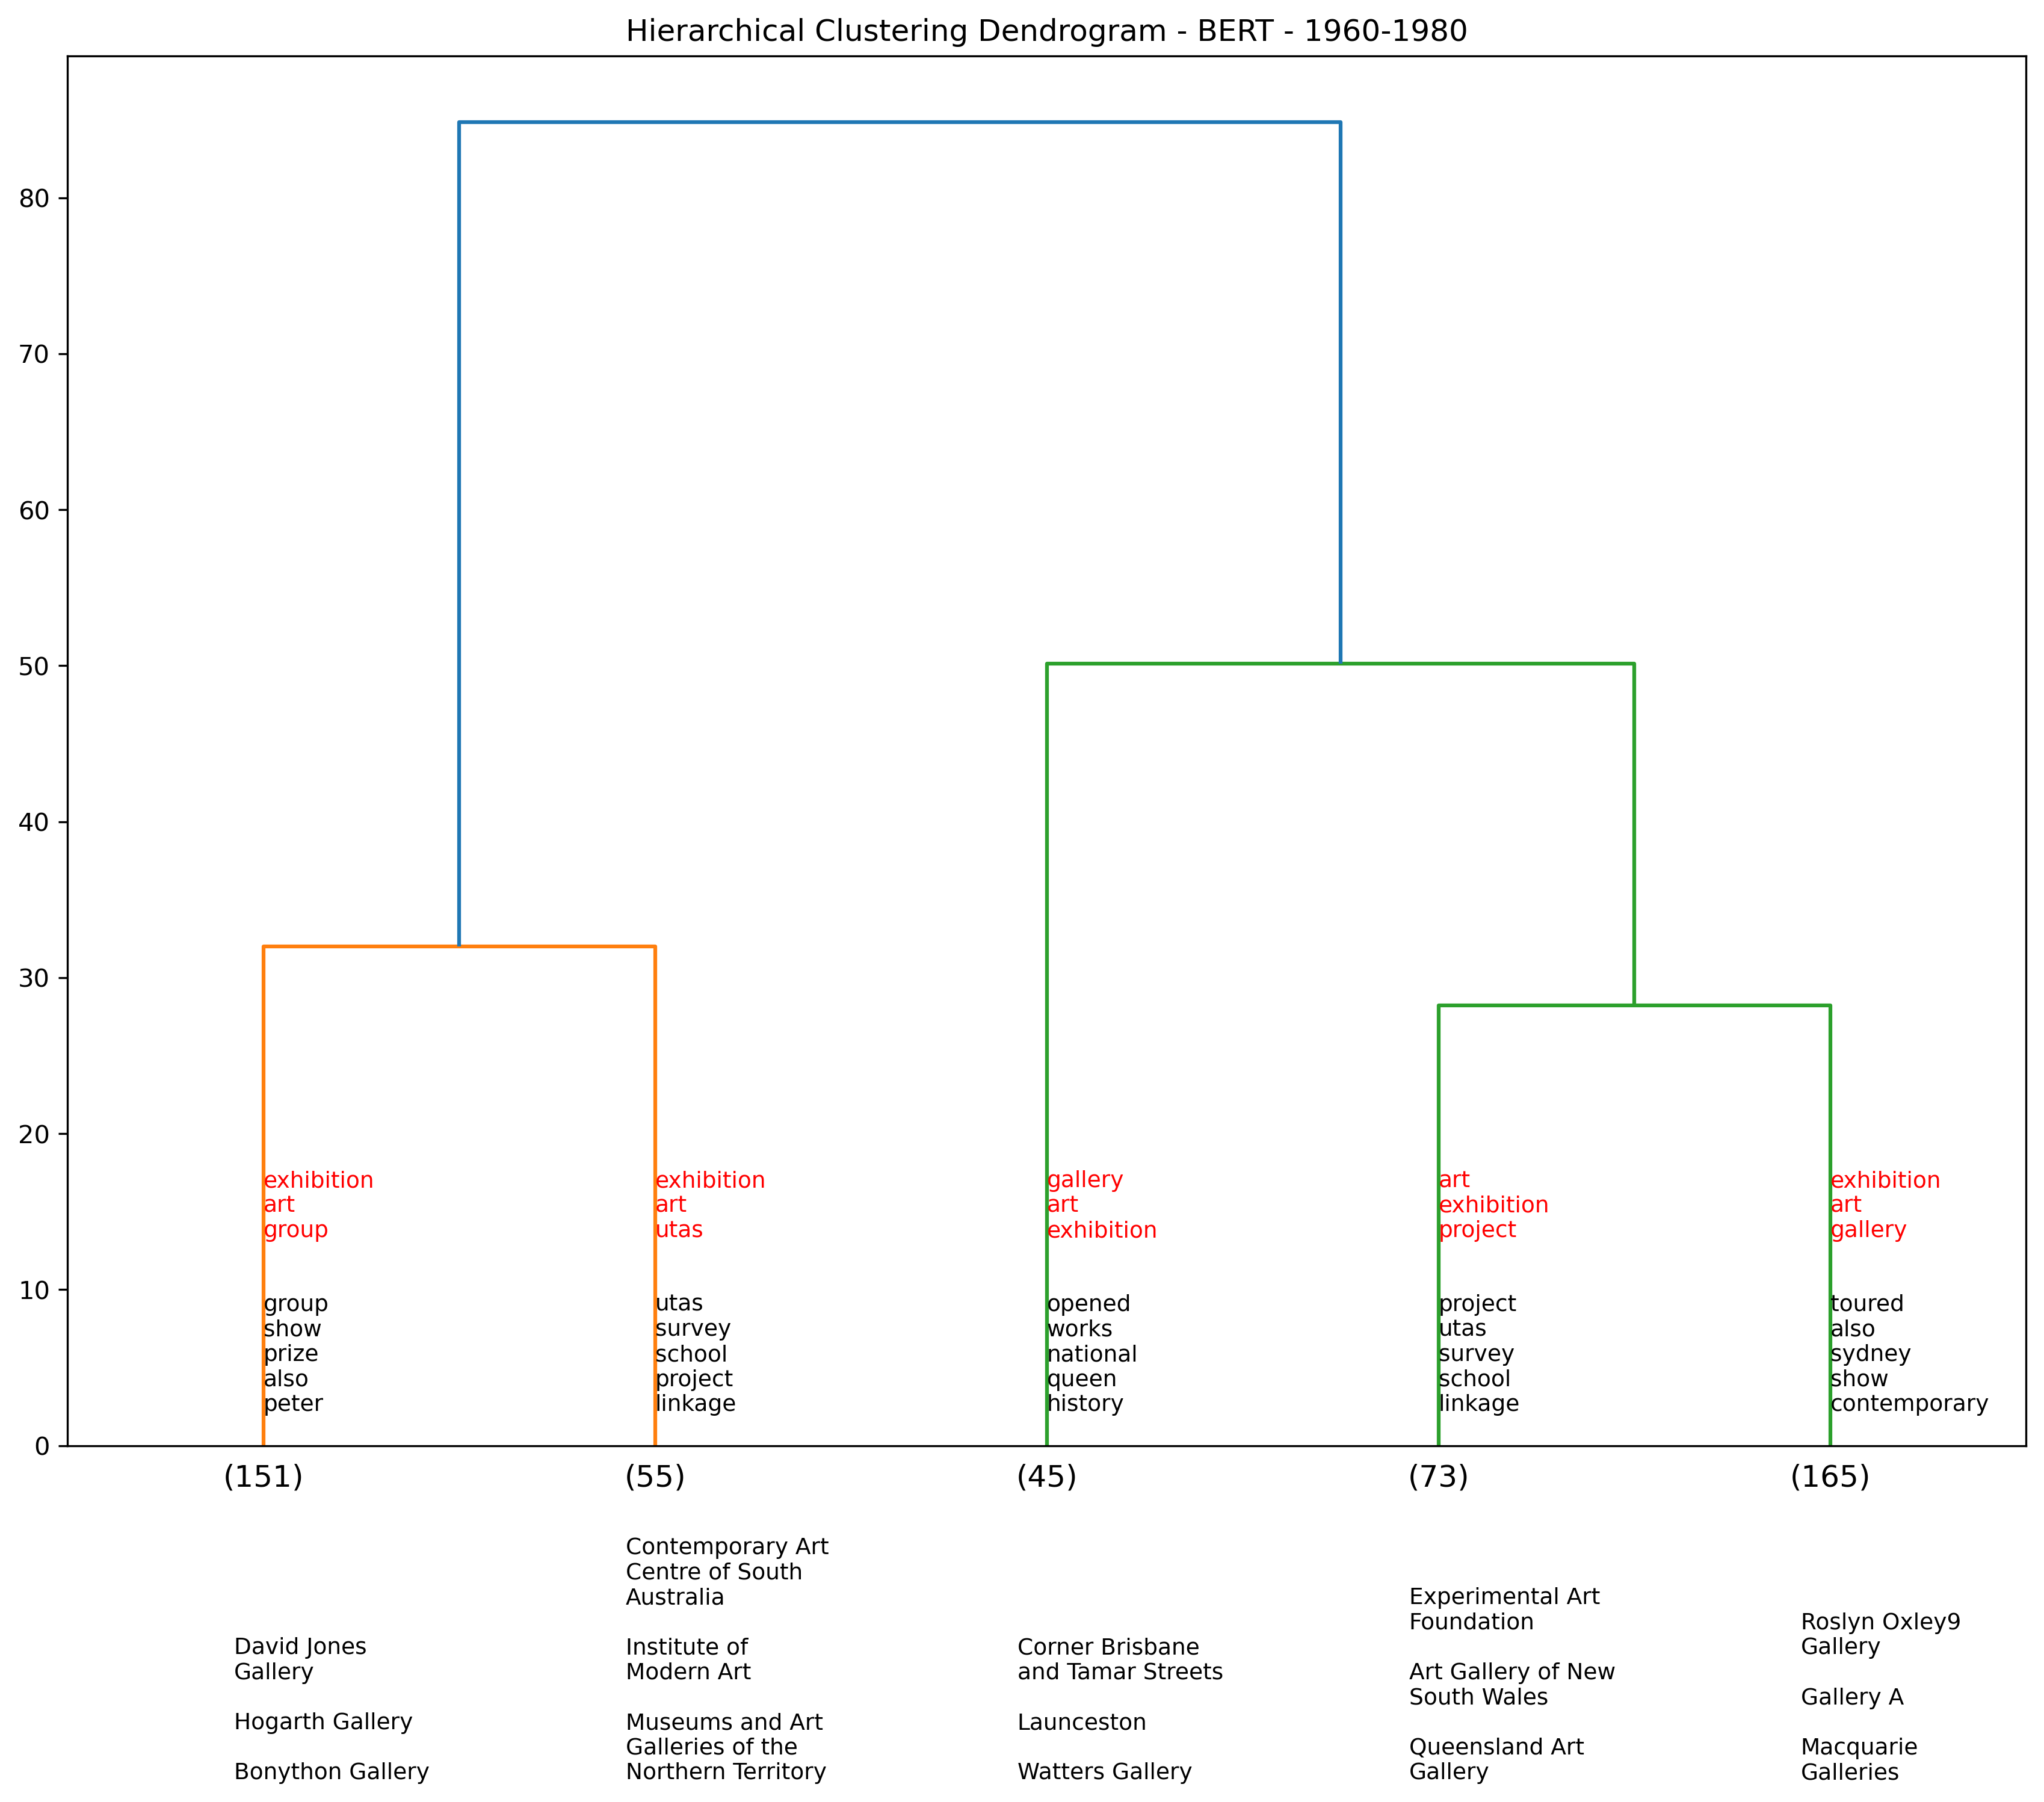

In [204]:
from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert_1960_1980.png')

#### 1980 - 2000

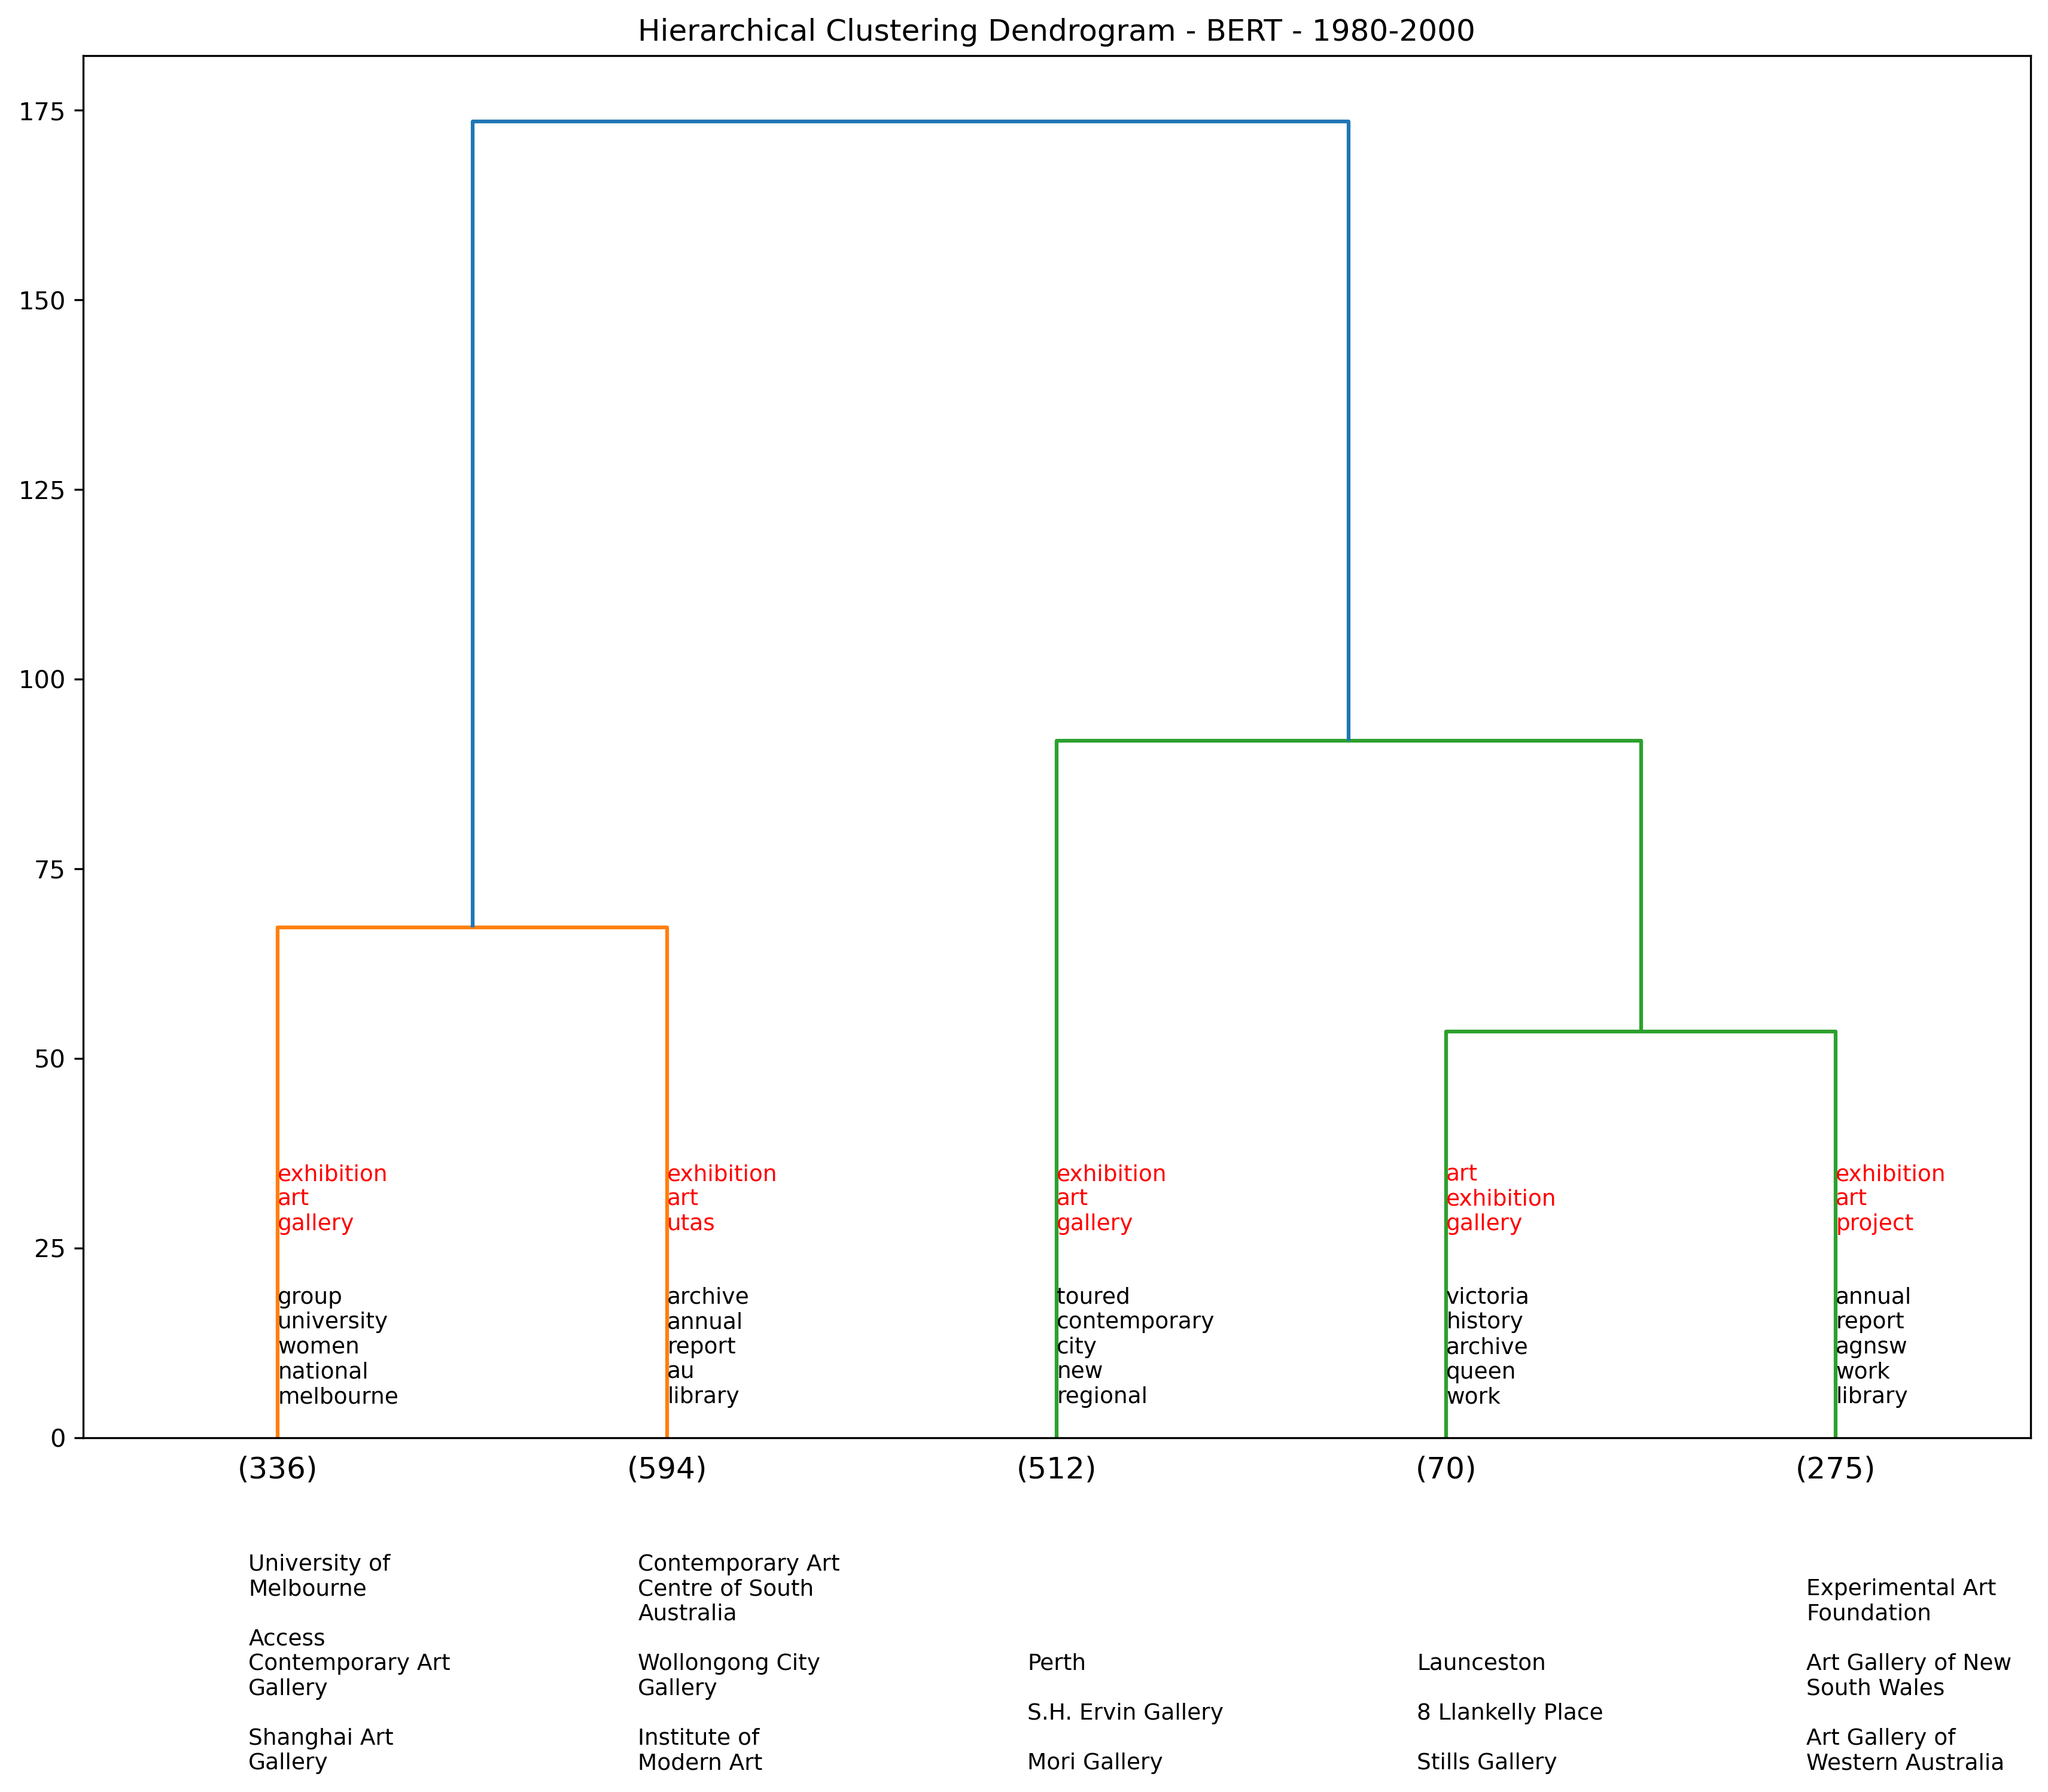

In [205]:
from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert_1980_2000.png')

#### 2000 - 2020

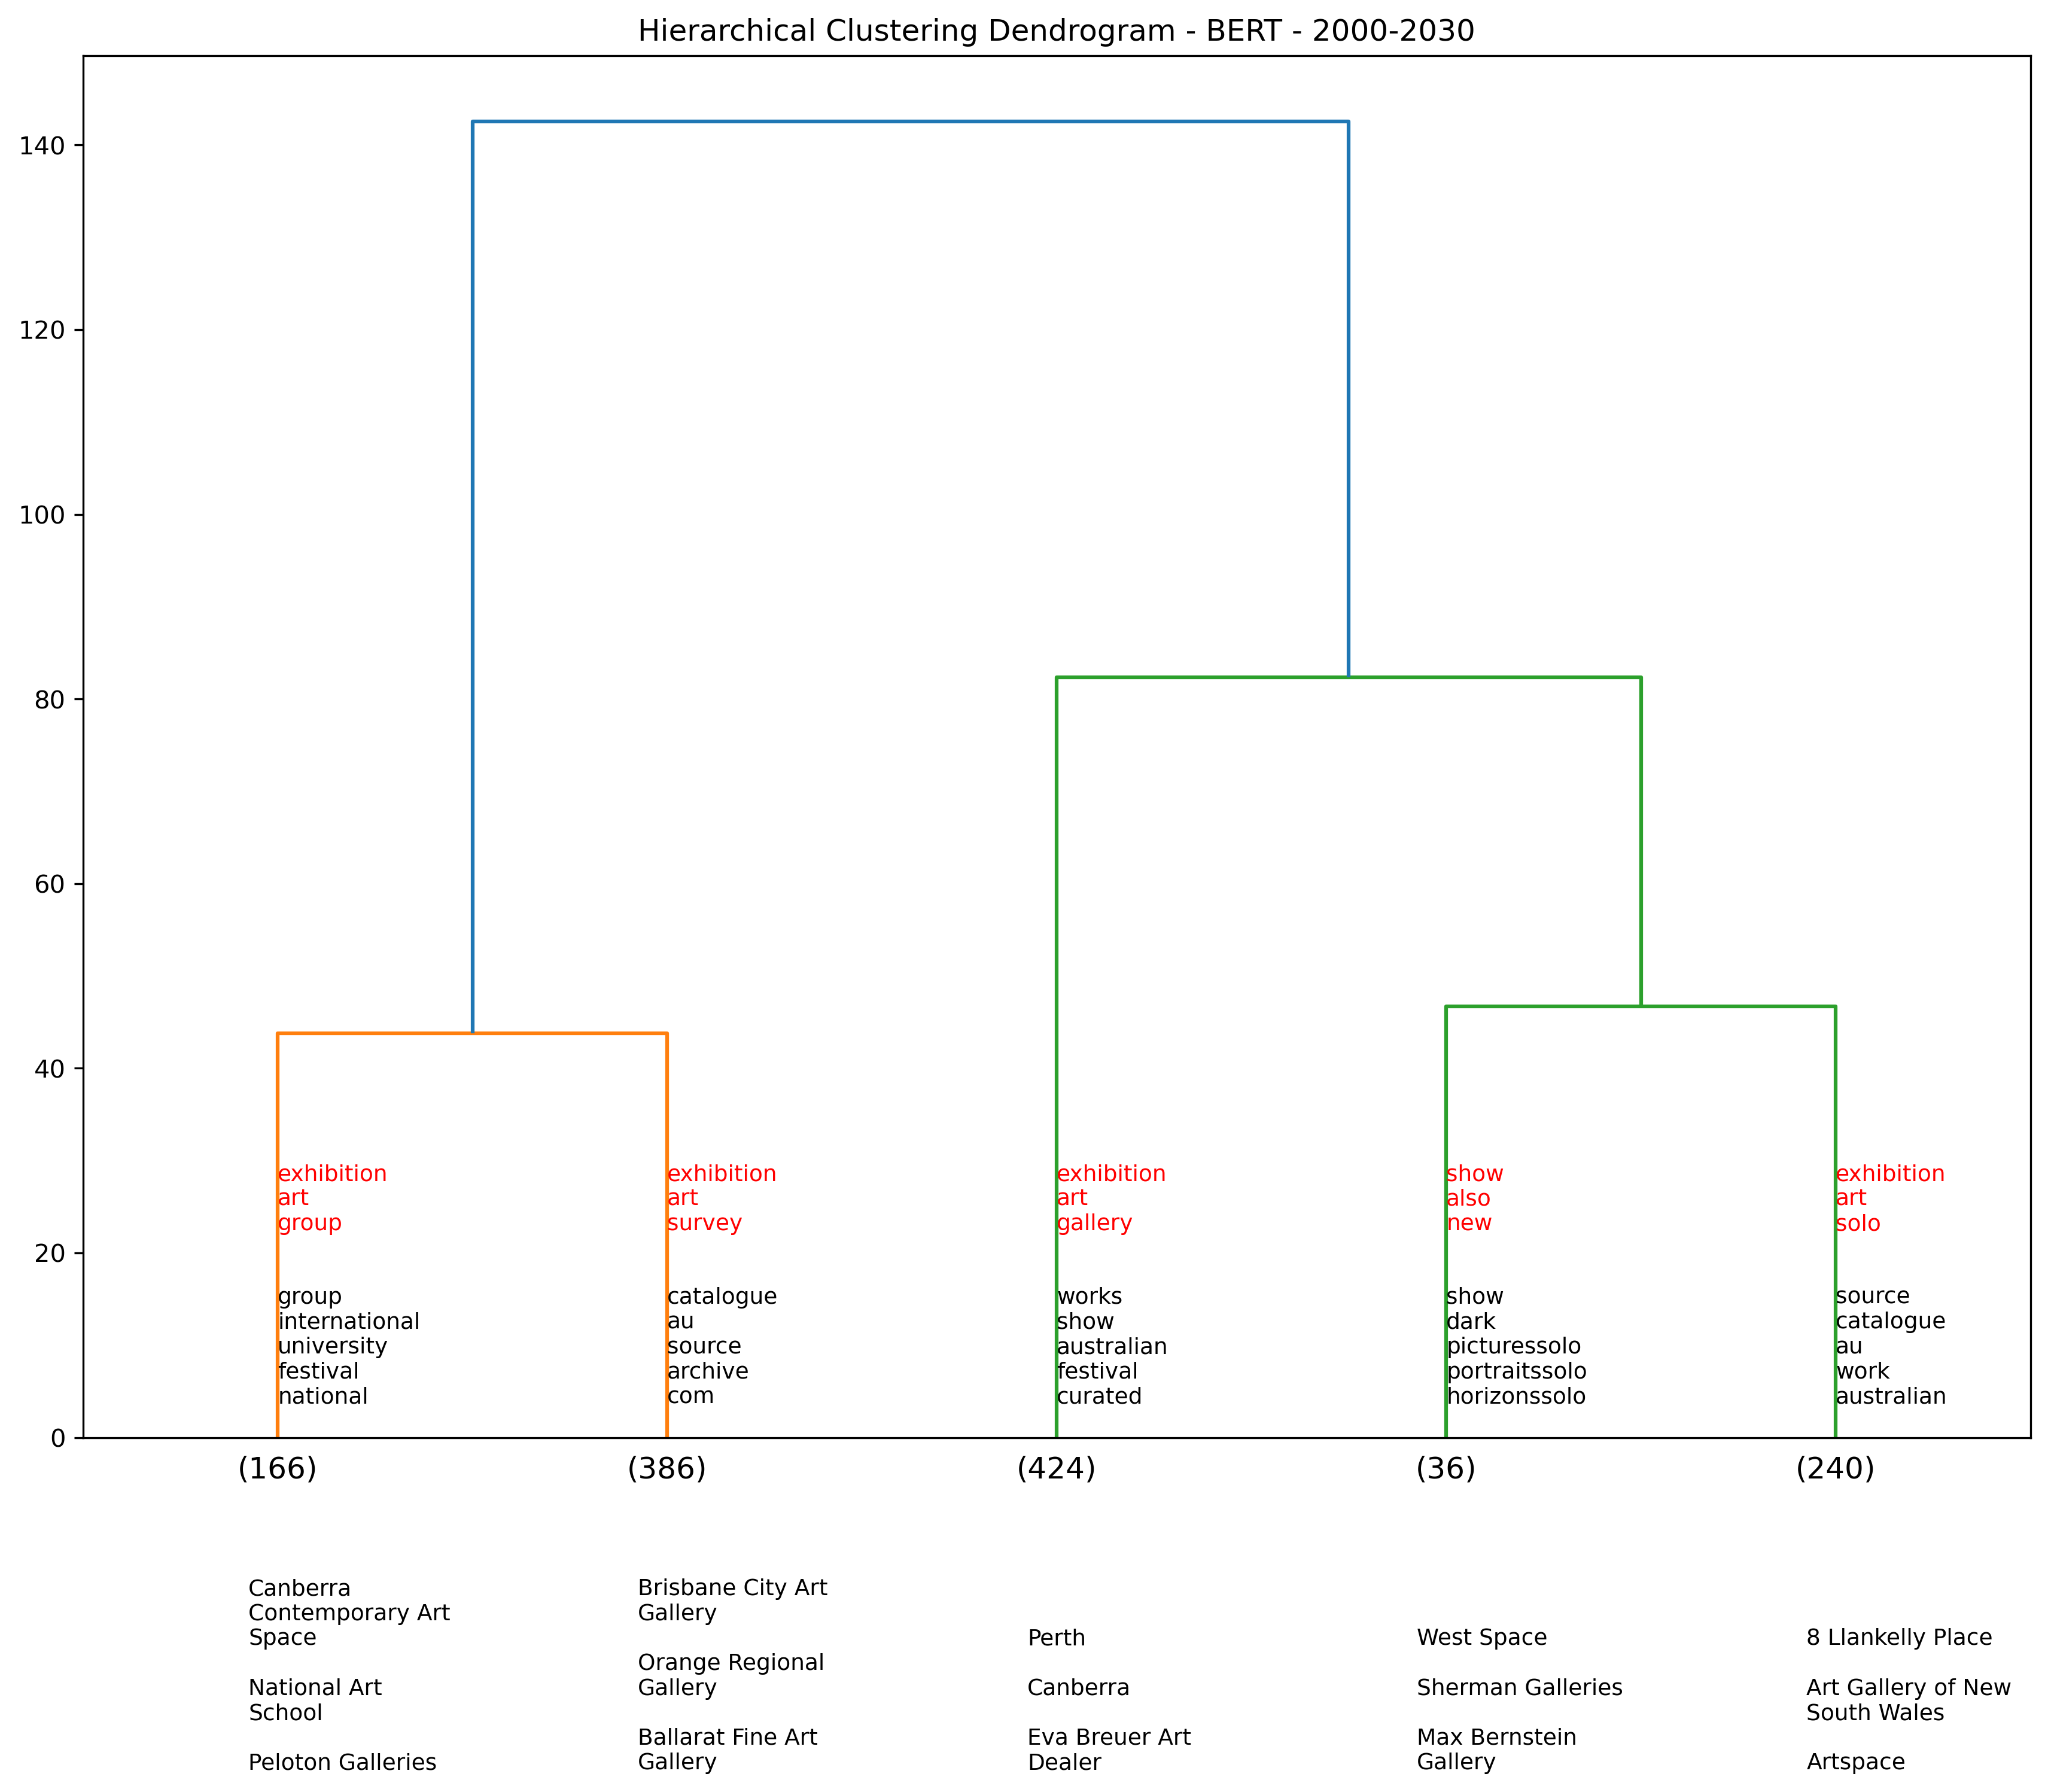

In [206]:
from IPython.display import Image
Image(filename='images/daao_tlc/outputnew_bert_2000_2030.png')

## Organisations
Similar to venues, we first produce a word cloud for common terms used in organisation names. We find that the most frequent terms are "Society", "Art", "Gallery", "Royal", and "Arts".

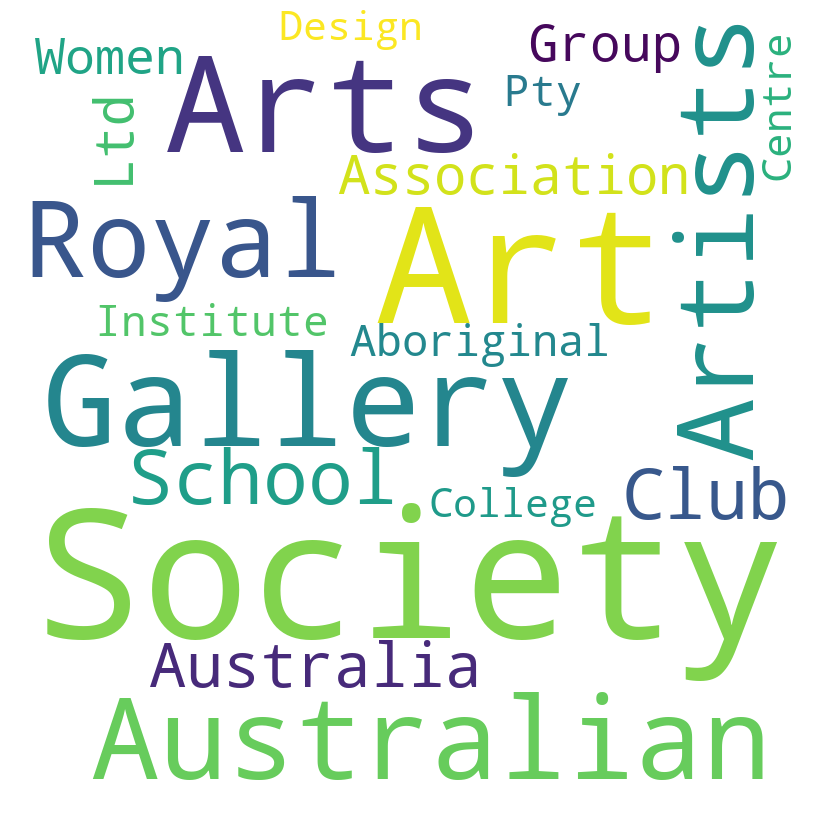

In [ ]:
# bios = pd.read_csv('data/daao_biography_level_202202211719.csv')
# bios = bios[['_id','primary_name.family_name','primary_name.given_names']]
# bios[bios['_id'].str.contains('4e1e1424b846f2dae7001dc0')]

with open("data/daao_persongroup_level.json") as json_file: daoo_org_data=json.load(json_file)

# create a list of all the place names
all_place_names = pd.json_normalize(daoo_org_data)['primary_name'].astype(str).tolist()

# create a list of all the words in the place names
all_words = []
for place_name in all_place_names:
    all_words.extend(word_tokenize(place_name))

# find top 100 most frequent words
most_freq_words = Counter(all_words).most_common(40)

# remove a list of all words that are not relevant
words_to_remove = [',','.','and','of','the','The','for',"'s",'&','(',')','J.','Melbourne',
                   'UK','VIC','London',
                   'Jane','Lapham','*','Adelaide',"'",'Sydney','NSW','New','South','Wales']

# remove the words from the list of most frequent words
most_freq_words = [word for word in most_freq_words if word[0] not in words_to_remove]

most_freq_words_dict = dict(most_freq_words)

# # add value of two keys
# most_freq_words_dict['Gallery'] = most_freq_words_dict['Gallery'] + most_freq_words_dict['Galleries']
# most_freq_words_dict['Museum'] = most_freq_words_dict['Museum'] + most_freq_words_dict['Museums']

# # remove key 'Gallery'
# most_freq_words_dict.pop('Galleries')
# most_freq_words_dict.pop('Museums')

# create a wordcloud with the most frequent words
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(most_freq_words_dict)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

As shown above, the use of dendrograms can be an interesting exercise to explore the data. The initial idea was to repeat the same approach with organisations to assess any latent patterns through this taxonomic approrach. However, we find that the data is not as rich as the venue data and that there are many organisations with no biographies, no summaries, and no relations to people records, exhibition records, etc.  Nevertheless we provide one dendrogram using organisation biographies.

Below is a list of the proportion of missing data for each field across DAAO organisations.

In [ ]:
# find the proportion of null values in each column
print((pd.json_normalize(daoo_org_data).isnull().sum()/pd.json_normalize(daoo_org_data).shape[0])[0:20])

biography              0.869957
_cls                   0.000000
editing_complete       0.922318
is_deleted             0.000000
is_featured            0.000000
is_locked              0.000000
is_primary             0.000000
is_shadow              0.000000
primary_name           0.000858
periods_active         0.959227
record_status          0.000000
residences             0.959442
roles                  0.000000
sources                0.913519
slug                   0.000000
summary                0.917167
related_stub_people    0.998927
_id.$oid               0.000000
date_created.$date     0.024678
date_modified.$date    0.069528
dtype: float64

In [ ]:
print((pd.json_normalize(daoo_org_data).isnull().sum()/pd.json_normalize(daoo_org_data).shape[0])[20:])

references                    0.896567
tags                          0.962017
type                          0.974464
types                         0.965665
related_events                0.972318
related_collections           0.985837
related_works                 0.922318
related_recognitions          0.996996
related_stub_person_groups    0.998927
copyright_agents              0.999571
urls                          0.896137
alternative_names             0.967811
locked_biographies            0.999356
other_occupations             0.996996
see_alsos                     0.982833
nla_id                        0.999356
source_database_ids           0.985837
dtype: float64


In [ ]:
# from bs4 import BeautifulSoup

# orgs = pd.DataFrame(columns=['name','summary','bio'])

# # pd.json_normalize(daoo_org_data)['biography'].isnull().sum()/pd.json_normalize(daoo_org_data).shape[0] # 87% of rows have no biography

# for i,row in pd.json_normalize(daoo_org_data).iterrows():
#     try:
#         try: row['biography'][0]['text']
#         except: continue

#         # try: period_start = row['periods_active'][0]['start']['_date']
#         # except: period_start = None

#         # try: period_end = row['periods_active'][0]['end']['_date']
#         # except: period_end = None

#         # use pandas.concat to append new row to dataframe
#         orgs = pd.concat([orgs, pd.DataFrame({'name': [row['primary_name']],
#                                                 'summary': [row['summary']],
#                                                 'bio': [row['biography'][0]['text']],
#                                                 # 'period_start': [period_start],
#                                                 # 'period_end': [period_end]
#                                                 })], ignore_index=True)
        
#     except:
#         print(i)
#         break

# # remove empty summary
# orgs['summary'].fillna('', inplace=True)

# # remove rows with stub text
# orgs = orgs[~orgs['bio'].isin(orgs['bio'].value_counts().head(5).index.to_list())]

# # combine summary and bio
# orgs['bio'] = orgs['summary'] + orgs['bio'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

# orgs = orgs[['name','bio']]

In [ ]:
# ### encode text using bert (takes 4mins to run)

# ### pre-process for NLP
# # Load the documents and their corresponding categorical variables into a Pandas dataframe
# df_org = pd.DataFrame({'text': orgs['bio'], 'category': orgs['name']})

# #add new column with count for each category
# df_org['cat_count'] = df_org.groupby('category')['category'].transform('count')
# df_org.drop_duplicates(inplace=True)

# # Clean the text
# stop_words = set(stopwords.words('english'))

# def clean_text(text):
#     text = re.sub('[^a-zA-Z]', ' ', text)
#     text = text.replace(',', '')
#     text = text.lower().split()
#     text = [word for word in text if word not in stop_words]
#     text = ' '.join(text)
#     return text

# df_org['clean_text'] = df_org['text'].apply(clean_text)

# # randomly sample 512 tokens from each row in df['clean_text']
# # some strings are smalle than 512
# df_org['clean_text_sampled'] = df_org['clean_text'].apply(lambda x: ' '.join(random.sample(x.split(' '), 350)) if len(x.split(' ')) >= 350 else x)
# X_bert_org = df_org['clean_text_sampled'].apply(lambda x: pd.Series(bert_encode([str(x)])[0]))

# # setting distance_threshold=0 ensures we compute the full tree.
# model_bert_org = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# model_bert_org = model_bert_org.fit(np.array(X_bert_org))

Biographical data for each organisation (~130 organisations) is used to create the clusters. From here we show the most common terms used in the organisation name for each cluster.

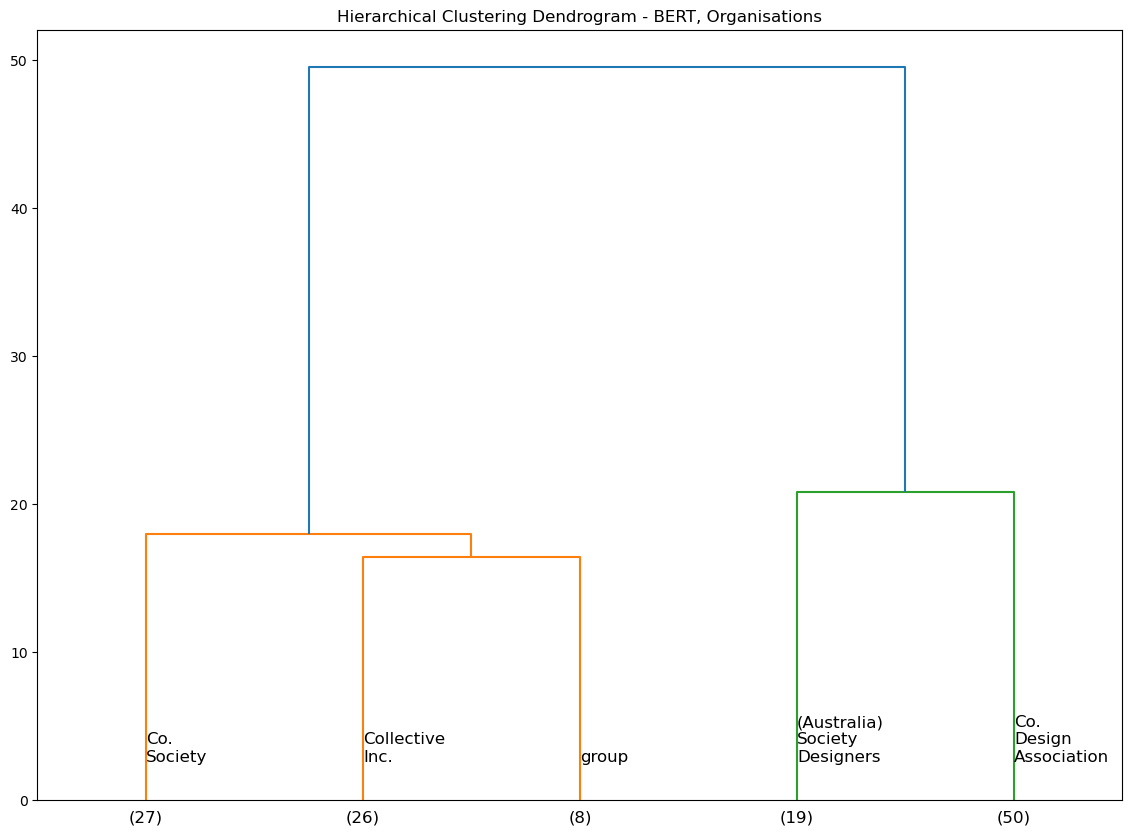

In [ ]:
# cut = 5
# l_matrix = get_linkage_matrix(model_bert_org)
# df_org['cluster'] = fcluster(l_matrix, cut, criterion='maxclust')
# dendrogram(l_matrix, orientation='top', truncate_mode="lastp", p=cut, show_leaf_counts=True)

# all_words = []

# for i in df_org['cluster'].unique():
#     cluster_docs = df_org[df_org['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     [all_words.append(i[0]) for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=5))]
    
# all_words_to_remove = find_duplicates(all_words, occurences=4)
# all_words_to_remove.extend(['h','co','e','test','Lapham','J.','Jane','','and','of','&','The','SymbioticA','Nevin','Smith'])

# for i in df_org['cluster'].unique():
#     cluster_docs = df_org[df_org['cluster'] == i]
#     # print(i, get_most_common_word(cluster_docs['clean_text']))
#     annot = "\n".join(i[0] for idx,i in enumerate(get_most_common_word(cluster_docs['category'], no_of_words=6,
#                                                                        more_words=all_words_to_remove)) if (idx < 3))
    
#     plt.annotate(annot, xy=(i/df_org['cluster'].nunique()-0.1, 0.05), 
#                  xytext=(i/df_org['cluster'].nunique()-0.1, 0.05), 
#                  xycoords='axes fraction', fontsize=12)
    
#     # annot2 = cluster_docs.sort_values('cat_count', ascending=False)['category'].values[0:3]
#     # annot2 = '\n\n'.join(['\n'.join(wrap(line, 18)) for line in [i.split(',')[0] for i in annot2]])
#     # # annot2 = '\n'.join(wrap(annot2, 18)) # breaks strings into new lines

#     # plt.annotate(annot2, xy=(i/df_org['cluster'].nunique()-0.115, -0.24), 
#     #             xytext=(i/df_org['cluster'].nunique()-0.115, -0.24), 
#     #             xycoords='axes fraction', fontsize=9)

# plt.title("Hierarchical Clustering Dendrogram - BERT, Organisations")

# # make figure bigger
# fig = plt.gcf()
# fig.set_size_inches(14, 10)

# plt.show()

from IPython.display import Image
Image(filename='images/daao_tlc/output5.png')

In [ ]:
# with open("data/daao_relation.json") as json_file: daao_relation_data=json.load(json_file)
# relation_df = pd.json_normalize(daao_relation_data)
# print(relation_df[((relation_df['obj._cls'] == 'PersonGroup') & (relation_df['subj._cls'] == 'Person'))]['obj._ref.$id.$oid'].shape)

# with open("data/daao_xparty.json") as json_file: daao_xparty_data=json.load(json_file)
# xparty_df = pd.json_normalize(daao_xparty_data)
# xparty_df.head()

# xparty_df[xparty_df['_cls']=='VersionedDocument.XParty.PersonGroup']['primary_name'].value_counts()

# org_df = pd.json_normalize(daoo_org_data)
# org_df[org_df['_id.$oid'].isin(relation_df[(relation_df['obj._cls'] == 'PersonGroup') & (relation_df['subj._cls'] == 'Person')]['obj._ref.$id.$oid'])]

# orgs_ppl = pd.DataFrame()

# for i,row in pd.json_normalize(daoo_org_data).iterrows():
#     try: 
#         related_people = []
#         for j,row2 in pd.json_normalize(row['related_stub_people']).iterrows():
#             related_people.extend([pd.json_normalize(row2['predicate'])['_id.$oid'].values[0], 
#                                 pd.json_normalize(row2['target'])['_id.$oid'].values[0]])

#         ppl = pd.DataFrame({'related_people':list(dict.fromkeys(related_people))})
#         ppl['organisation'] = row['primary_name']
#         orgs_ppl = pd.concat([orgs_ppl, ppl], ignore_index=True)
#     except: continue

## Temporal analysis of venues

To further explore frequently used terms in place names, we produce an interactive time series of the number of events per decade by associated terms.

Before the visuals, we provide an ordered list of the decades with the most event activity, and also a list of the top 20 most frequent terms used in place names.

In [207]:
events_df = dfs_rich.copy()

# create a new column with the decade of start year
events_df['decade'] = events_df['start_year'].apply(lambda x: str(x)[:3] + '0')
events_df['decade'] = events_df['decade'].apply(lambda x: '2000' if x == '2020' else x)
events_df['decade'] = events_df['decade'].astype(int)
events_df['decade'].value_counts()

2000    2286
1990    2272
1980    1413
1970     651
2010     526
1960     159
1950      90
1940      41
1930      40
1920      39
1900      33
1910      31
Name: decade, dtype: int64

In [208]:
most_freq_words_dict2

{'Gallery': 3929,
 'Art': 3404,
 'Centre': 665,
 'Museum': 775,
 'University': 627,
 'Contemporary': 594,
 'Foundation': 431,
 'Experimental': 429,
 'City': 367,
 'National': 328,
 'Modern': 318,
 'Regional': 283,
 'Institute': 254,
 'Arts': 229,
 'Australian': 197,
 'Fine': 184,
 'Place': 121,
 'Region': 108,
 'School': 75,
 'Hall': 68,
 'Space': 63,
 'College': 58,
 'House': 57}

In [210]:
words_by_decade = pd.DataFrame()

for key in most_freq_words_dict2:
    words_this_decade = events_df[events_df['place_address'].str.contains(key, na=False)]\
                        .groupby('decade')['place_address']\
                        .count()\
                        .reset_index(name='count')\
                        .sort_values(['decade'], ascending=True)
    words_this_decade['term'] = key
    words_by_decade = pd.concat([words_by_decade, words_this_decade], ignore_index=True)

In [211]:
import plotly.express as px
fig = px.line(words_by_decade, x="decade", y="count", color='term',
                title='Count of each term by decade')

# # make figure size bigger
# # fig.update_layout(
# #     autosize=False,
# #     width=700,
# #     height=500,
# # )

fig.show()

In [212]:
# events_df['diff'] = events_df['end_year'] - events_df['start_year']
# # events_df[(events_df['place_name'].str.contains('Contemporary')) & (events_df['diff'] > 1)]

# using start_date, end_date, place_name, calculate the difference between start_date of the first event in an venue and end_date of the last event in that venue
places_with_start_end = []
[places_with_start_end.extend([p, events_df.loc[events_df['place_address'] == p, 'start_year'].min(), 
                              events_df.loc[events_df['place_address'] == p, 'end_year'].max()] for p in events_df['place_address'].unique())]

places_with_start_end = pd.DataFrame(places_with_start_end)
places_with_start_end.columns = ['place_address', 'start_year', 'end_year']
places_with_start_end['diff'] = places_with_start_end['end_year'] - places_with_start_end['start_year']
places_with_start_end = places_with_start_end[places_with_start_end['diff'] >= 0]
# places_with_start_end.sort_values('diff', ascending=False)

Beyond the above time series, we also provide a series of bar charts, however instead of illustrating event activity within a certain decade, we plot the number of venues active across time. We calculate the start and end of a venue's "lifespan" by using the earliest and latest event date associated with a venue. We do this by filtering on venues with associated terms in the place name.

Most bar charts follow the same upwards trends shown in the above time series, however some terms that highlight some different trajectories consist of "contemporary", "society", "experimental" and "space".

In [231]:
decade_placeholder = pd.DataFrame([0] * 13, index=range(1900, 2020+1, 10)).reset_index().rename(columns={'index':'decade', 0:'count'})
decade_placeholder['decade'] = decade_placeholder['decade'].astype(str)

for term in most_freq_words_dict2:
    # create a wide form of contemporary with each decade as a column and a binary value for whether the venue existed in that decade
    # use start_year as the start and end_year as the end of the venue
    contemporary = places_with_start_end[(places_with_start_end['place_address'].str.contains(term))].sort_values('start_year', ascending=True)
    contemporary_wide = pd.DataFrame()

    for i,row in contemporary.iterrows():
        for year in range(int(row['start_year']), int(row['end_year'])+1): 
            contemporary_wide.loc[row['place_address'], str(year)[:3] + '0'] = 1

    contemporary_wide = contemporary_wide.\
        fillna(0).\
        reset_index().\
        rename(columns={'index':'place_address'}).\
        sum().tail(-1).\
        reset_index().\
        rename(columns={'index':'decade', 0:'count'})
    
    contemporary_wide = pd.merge(contemporary_wide, decade_placeholder, on='decade', how='outer')
    contemporary_wide['count'] = contemporary_wide['count_x'] + contemporary_wide['count_y']
    contemporary_wide = contemporary_wide[['decade', 'count']].sort_values('decade', ascending=True)

    fig = px.bar(contemporary_wide, x="decade", y='count',
                    title=f'Number of venues that existed in each decade, {term}')

    # remove y-axis label
    fig.update_yaxes(title_text='')
    fig.update_xaxes(title_text='')

    # # make figure size bigger
    # fig.update_layout(
    #     autosize=False,
    #     width=700,
    #     height=400,
    # )

    fig.show()

### Proportions
We repeat the same temporal visuals as above, however this time we plot the proportions to effectively normalise the data with respect to the number of events across decades, and the number of venues that existed across time, repsectively.

Note that the y-axis limits in the bar charts changes for each term.

In [233]:
words_by_decade_prop = []

# find the proportions of each word in each decade
for i in most_freq_words_dict2.keys():
    for j in events_df['decade'].unique():
        prop = events_df[(events_df['place_address'].str.contains(i)) & (events_df['decade'] == j)].shape[0] /events_df[events_df['decade'] == j].shape[0]
        words_by_decade_prop.append([i,j,prop])
    
words_by_decade_prop = pd.DataFrame(words_by_decade_prop)
words_by_decade_prop.columns = ['word','decade','proportion']

In [234]:
# plot proportion of each term by decade
# make it interactive

import plotly.express as px

fig = px.line(words_by_decade_prop.sort_values('decade'), x="decade", y="proportion", color='word',
                title='Proportion of each term by decade')

# make figure size bigger
# fig.update_layout(
#     autosize=False,
#     width=700,
#     height=500,
# )

fig.show()

In [236]:
allplaces_wide = pd.DataFrame()

for i,row in places_with_start_end.iterrows():
    for year in range(int(row['start_year']), int(row['end_year'])+1): 
        allplaces_wide.loc[row['place_address'], str(year)[:3] + '0'] = 1

decade_placeholder_forprop = allplaces_wide.\
                            fillna(0).\
                            reset_index().\
                            rename(columns={'index':'place_address'}).\
                            sum().tail(-1).\
                            reset_index().\
                            rename(columns={'index':'decade', 0:'count'}).\
                            sort_values('decade', ascending=True)

In [238]:
for term in most_freq_words_dict2:
    # create a wide form of contemporary with each decade as a column and a binary value for whether the venue existed in that decade
    # use start_year as the start and end_year as the end of the venue
    contemporary = places_with_start_end[(places_with_start_end['place_address'].str.contains(term))].sort_values('start_year', ascending=True)
    contemporary_wide = pd.DataFrame()

    for i,row in contemporary.iterrows():
        for year in range(int(row['start_year']), int(row['end_year'])+1): 
            contemporary_wide.loc[row['place_address'], str(year)[:3] + '0'] = 1

    contemporary_wide = contemporary_wide.\
        fillna(0).\
        reset_index().\
        rename(columns={'index':'place_address'}).\
        sum().tail(-1).\
        reset_index().\
        rename(columns={'index':'decade', 0:'count'})
    
    contemporary_wide = pd.merge(contemporary_wide, decade_placeholder_forprop, on='decade', how='outer')
    contemporary_wide['prop'] = np.where(contemporary_wide['count_x'] > 0, 
                                     contemporary_wide['count_x']/contemporary_wide['count_y'], 0)
    contemporary_wide = contemporary_wide[['decade', 'prop']].sort_values('decade', ascending=True)

    fig = px.bar(contemporary_wide, x="decade", y='prop',
                    title=f'Number of venues that existed in each decade, {term}')

    # remove y-axis label
    fig.update_yaxes(title_text='')
    fig.update_xaxes(title_text='')

    # make figure size bigger
    # fig.update_layout(
    #     autosize=False,
    #     width=700,
    #     height=400,
    # )

    fig.show()